# Setup

## Imports

In [1]:
import QuantumToolbox as qt
import SuperconductingCavities as SC
import CairoMakie as cm
using Revise
using Dates
import JSON3

using ProgressMeter

import Optim as opt

using Logging
using MiniLoggers

┌ Info: new driver key :netcdf, updating backendlist.
└ @ NetCDFExt /home/gr400/.julia/packages/YAXArrayBase/Xj43k/ext/NetCDFExt.jl:81


## Logger Setups

In [2]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(21) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

# Loading Model and json

In [3]:
Mode4 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode4/Mode4.json");
proj_dict = SC.Utils.Get_Projection_Ops(Mode4.dressed_states);

device_config = JSON3.read("device_config_files/config_multimode.json", Dict{Any, Any});

In [4]:
GLOBAL_SAVE_CALIBRATE = true;

# Calibrating Pulses

## Qubit Pulses

### Guasisan g -> e

In [5]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ge"]["sigma"]))

Target σ: 0.023251488095238096


#### Getting Stark Shift

[2024-11-08 17:01:10] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


[2024-11-08 17:01:22] Info: Done With Floquet Sweep
[2024-11-08 17:01:23] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00036035585027298427	 0.008953731399661245	 2.006707644607207
Stark shift res: [0.00036035585027298427, 55.65597982200114]


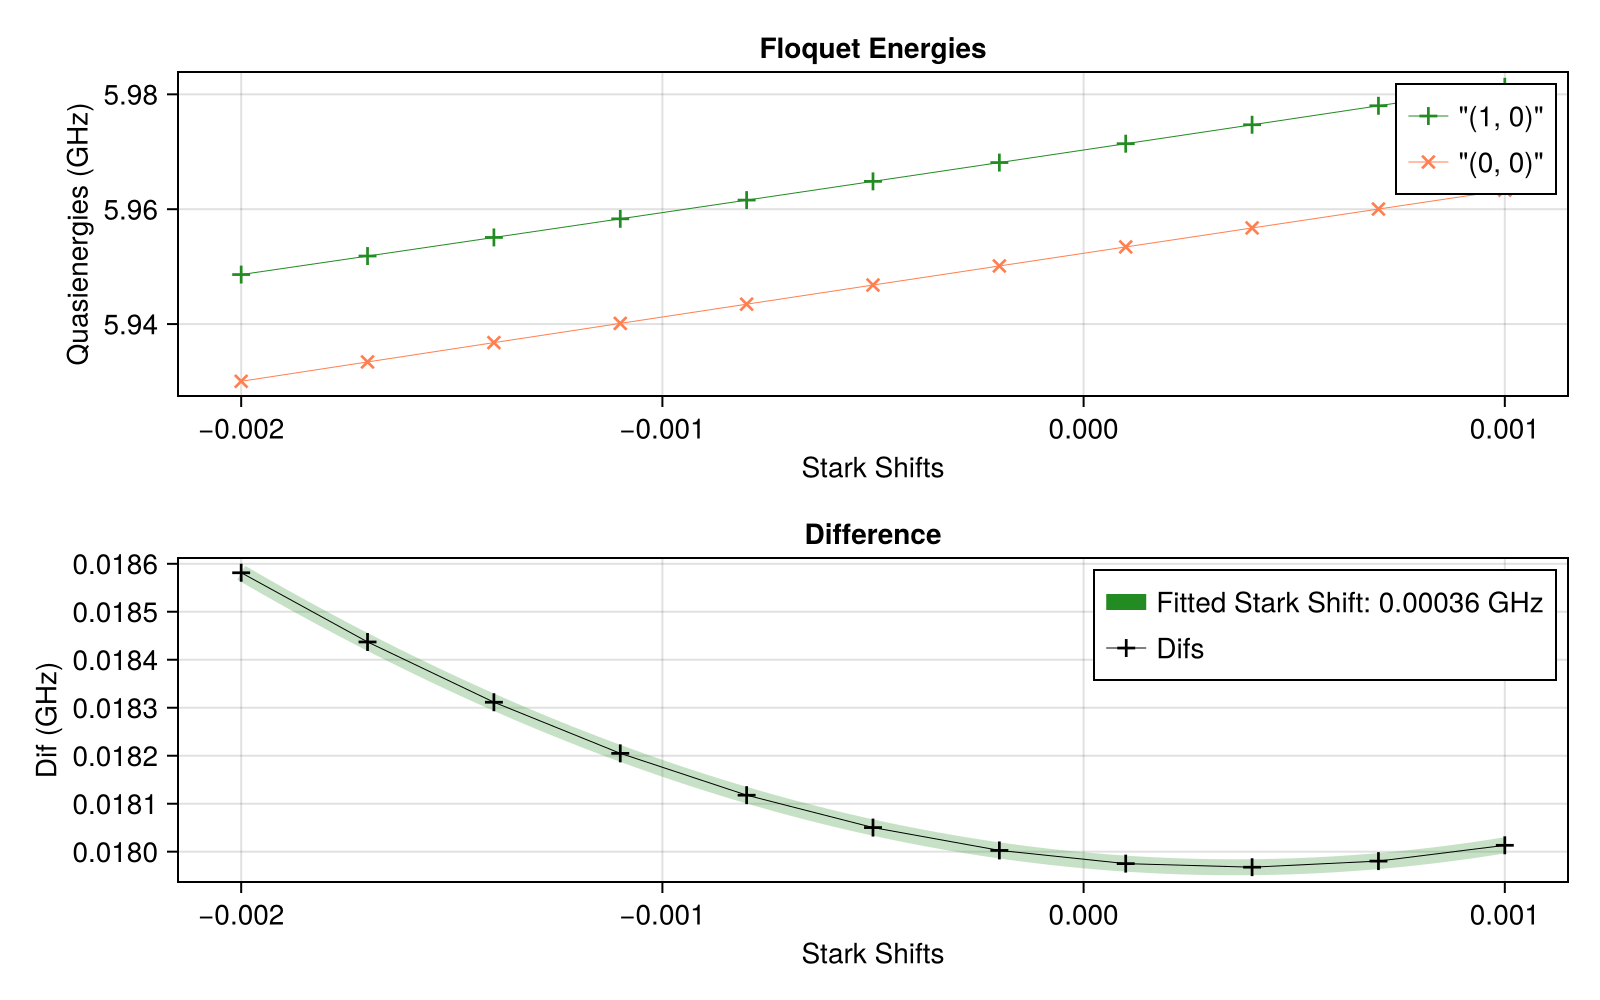

In [6]:
ge_ε = 0.00538
drive_op = Mode4.n̂ₜ
state1 = (0,0)
state2 = (1,0)

stark_shift_list = collect(LinRange(-0.002, 0.001, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode4, state1, state2, ge_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))
ge_stark_shift = stark_shift_res[1];

#### $|1,0\rangle+|0,1\rangle \to |0,0\rangle+|1,1\rangle$

In [7]:

ψ1 = Mode4.dressed_states[(1,0)]+Mode4.dressed_states[(0,1)]
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode4.dressed_states[(0,0)]+Mode4.dressed_states[(1,1)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d_e0 = Mode4.dressed_energies[(1,0)]-Mode4.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode4.dressed_energies[(1,1)]-Mode4.dressed_energies[(0,1)]+ge_stark_shift

freq_d = (freq_d_e0+freq_d_g1)/2

check_op = proj_dict[(0,0)]+proj_dict[(1,1)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

#qubit_ε = qubit_ε

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_half = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 17:01:36] Info: On Level 1
[2024-11-08 17:01:36] Info: On Step 1: t = 90.0
[2024-11-08 17:01:36] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 17:01:40] Info: Time Evolution Complete
[2024-11-08 17:01:40] Info: Done with Level_1_step_1
[2024-11-08 17:01:40] Info: Using Check Op
[2024-11-08 17:01:40] Info: Accurace: 0.9969219309231419
[2024-11-08 17:01:40] Info: ------------------------------------------------------------------------------
[2024-11-08 17:01:40] Info: On Step 2: t = 92.5
[2024-11-08 17:01:40] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:01:42] Info: Time Evolution Complete
[2024-11-08 17:01:42] Info: Done with Level_1_step_2
[2024-11-08 17:01:42] Info: Using Check Op
[2024-11-08 17:01:42] Info: Accurace: 0.9993720864991129
[2024-11-08 17:01:42] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999437
  "freq_d"        => 4.60381

In [8]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_1/2"] = deepcopy(qubit_ge_half)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999437
  "freq_d"        => 4.60381

In [9]:
ψ = Mode4.dressed_states[(1,0)]+Mode4.dressed_states[(0,1)]
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_half_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_1/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:03:18.050
It is being saved at: Data/
[2024-11-08 17:03:18] Info: Running operator q_ge_1/2
[2024-11-08 17:03:18] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-08 17:03:26] Info: Time Evolution Complete
[2024-11-08 17:03:26] Info: Saving Steps
[2024-11-08 17:03:36] Info: Done with Step_1
[2024-11-08 17:03:36] Info: Done With Running Sequence
[2024-11-08 17:03:36] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [10]:
EVs = SC.Utils.Get_EVs(q_ge_half_res["states"], proj_dict);

[2024-11-08 17:03:42] Info: Making Plot


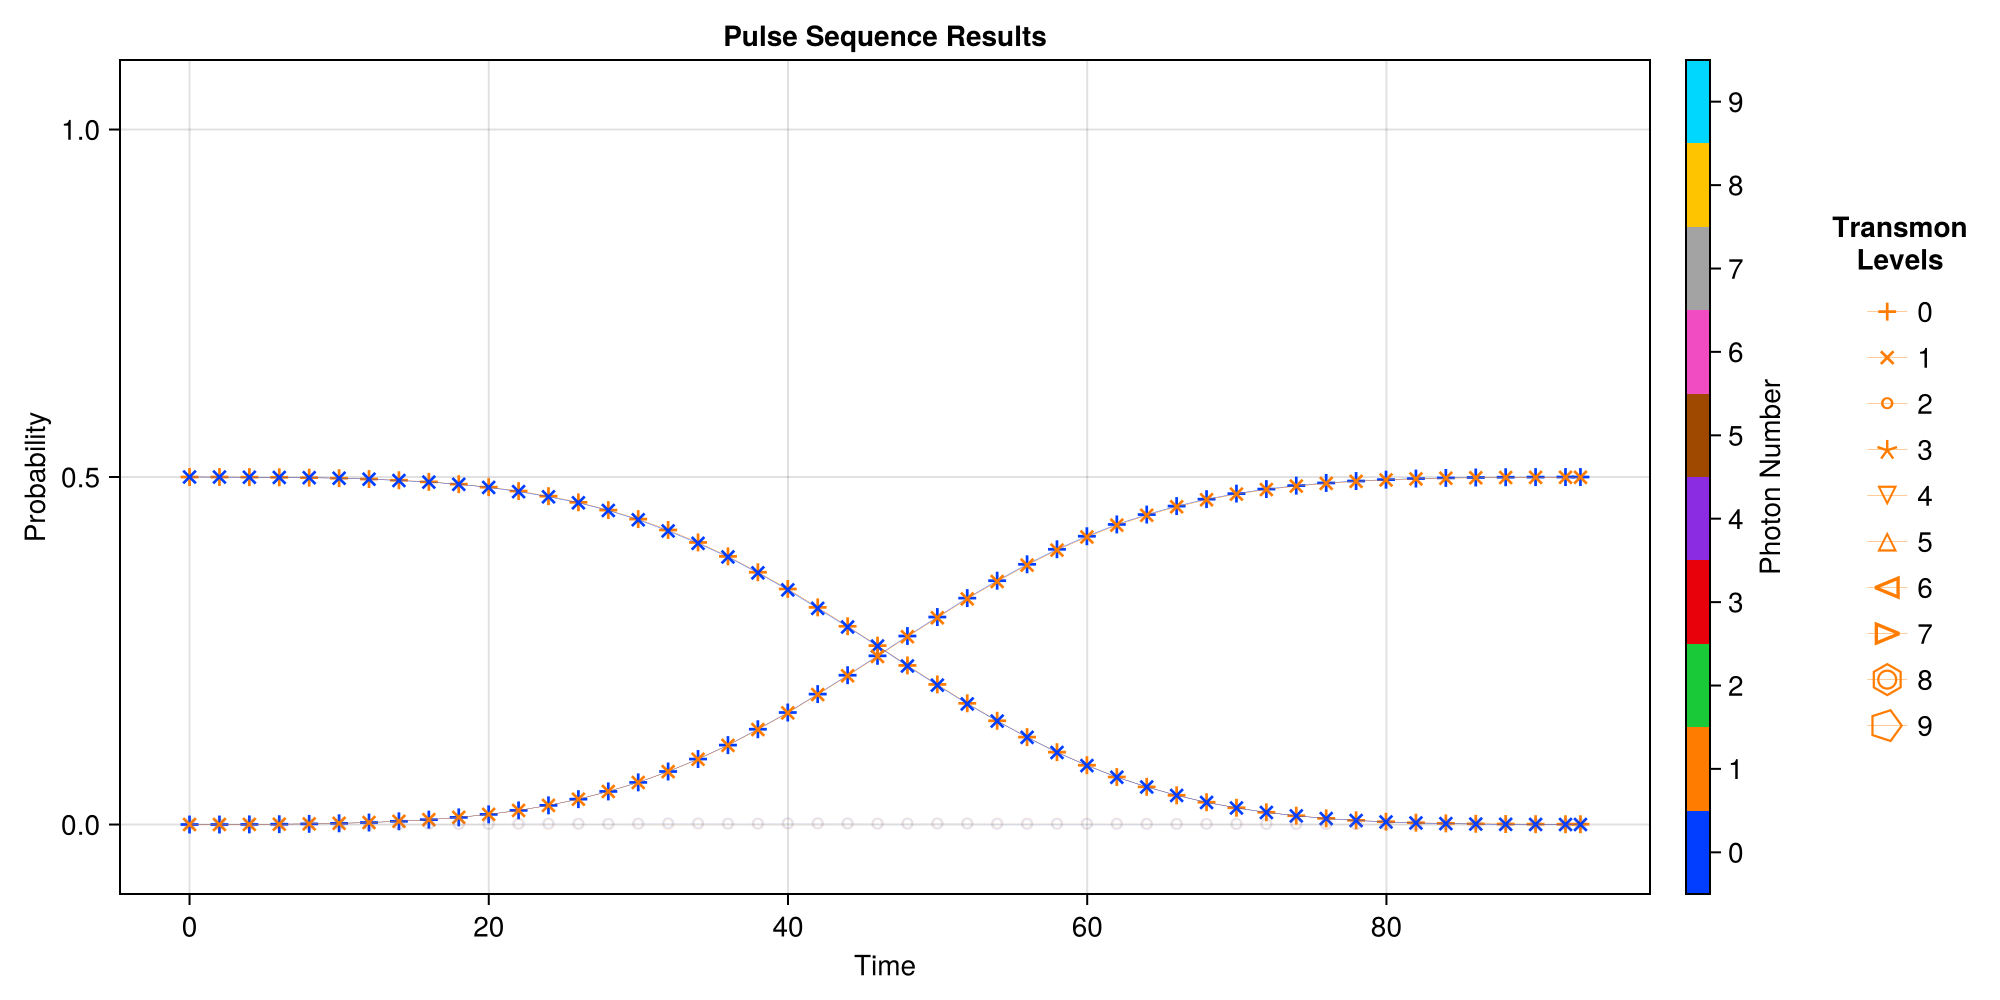

CairoMakie.Screen{IMAGE}


In [11]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge_half_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1)])

In [12]:
println(EVs[(0,0)][end])
println(EVs[(1,1)][end])

0.4999678827344847 + 4.349250050109031e-18im
0.4995568216320255 - 2.5665458792170363e-17im


In [13]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997306859885 - 2.1232801079952296e-17im

#### $|0,0\rangle \to |1,0\rangle$

In [14]:
state1 = (0,0)
state2 = (1,0)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge0_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:03:50] Info: On Level 1
[2024-11-08 17:03:50] Info: On Step 1: t = 90.0
[2024-11-08 17:03:50] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 17:03:55] Info: Time Evolution Complete
[2024-11-08 17:03:55] Info: Done with Level_1_step_1
[2024-11-08 17:03:55] Info: Accurace: 0.9968850655760908
[2024-11-08 17:03:55] Info: ------------------------------------------------------------------------------
[2024-11-08 17:03:55] Info: On Step 2: t = 92.5
[2024-11-08 17:03:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 17:04:00] Info: Time Evolution Complete
[2024-11-08 17:04:00] Info: Done with Level_1_step_2
[2024-11-08 17:04:00] Info: Accurace: 0.9993370711376627
[2024-11-08 17:04:00] Info: ------------------------------------------------------------------------------
[2024-11-08 17:04:00] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999401
  "freq_d"        => 4.60391

In [15]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_0"] = deepcopy(qubit_ge0_opt_res)
end


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999401
  "freq_d"        => 4.60391

In [16]:
ψ = Mode4.dressed_states[(0,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge0_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:05:39.378
It is being saved at: Data/
[2024-11-08 17:05:39] Info: Running operator q_ge_0
[2024-11-08 17:05:39] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 08s (ETA: 0h 00m 00s)
[2024-11-08 17:05:47] Info: Time Evolution Complete
[2024-11-08 17:05:47] Info: Saving Steps
[2024-11-08 17:05:48] Info: Done with Step_1
[2024-11-08 17:05:48] Info: Done With Running Sequence
[2024-11-08 17:05:48] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [17]:
EVs_ge0 = SC.Utils.Get_EVs(q_ge0_res["states"], proj_dict);

[2024-11-08 17:05:49] Info: Making Plot


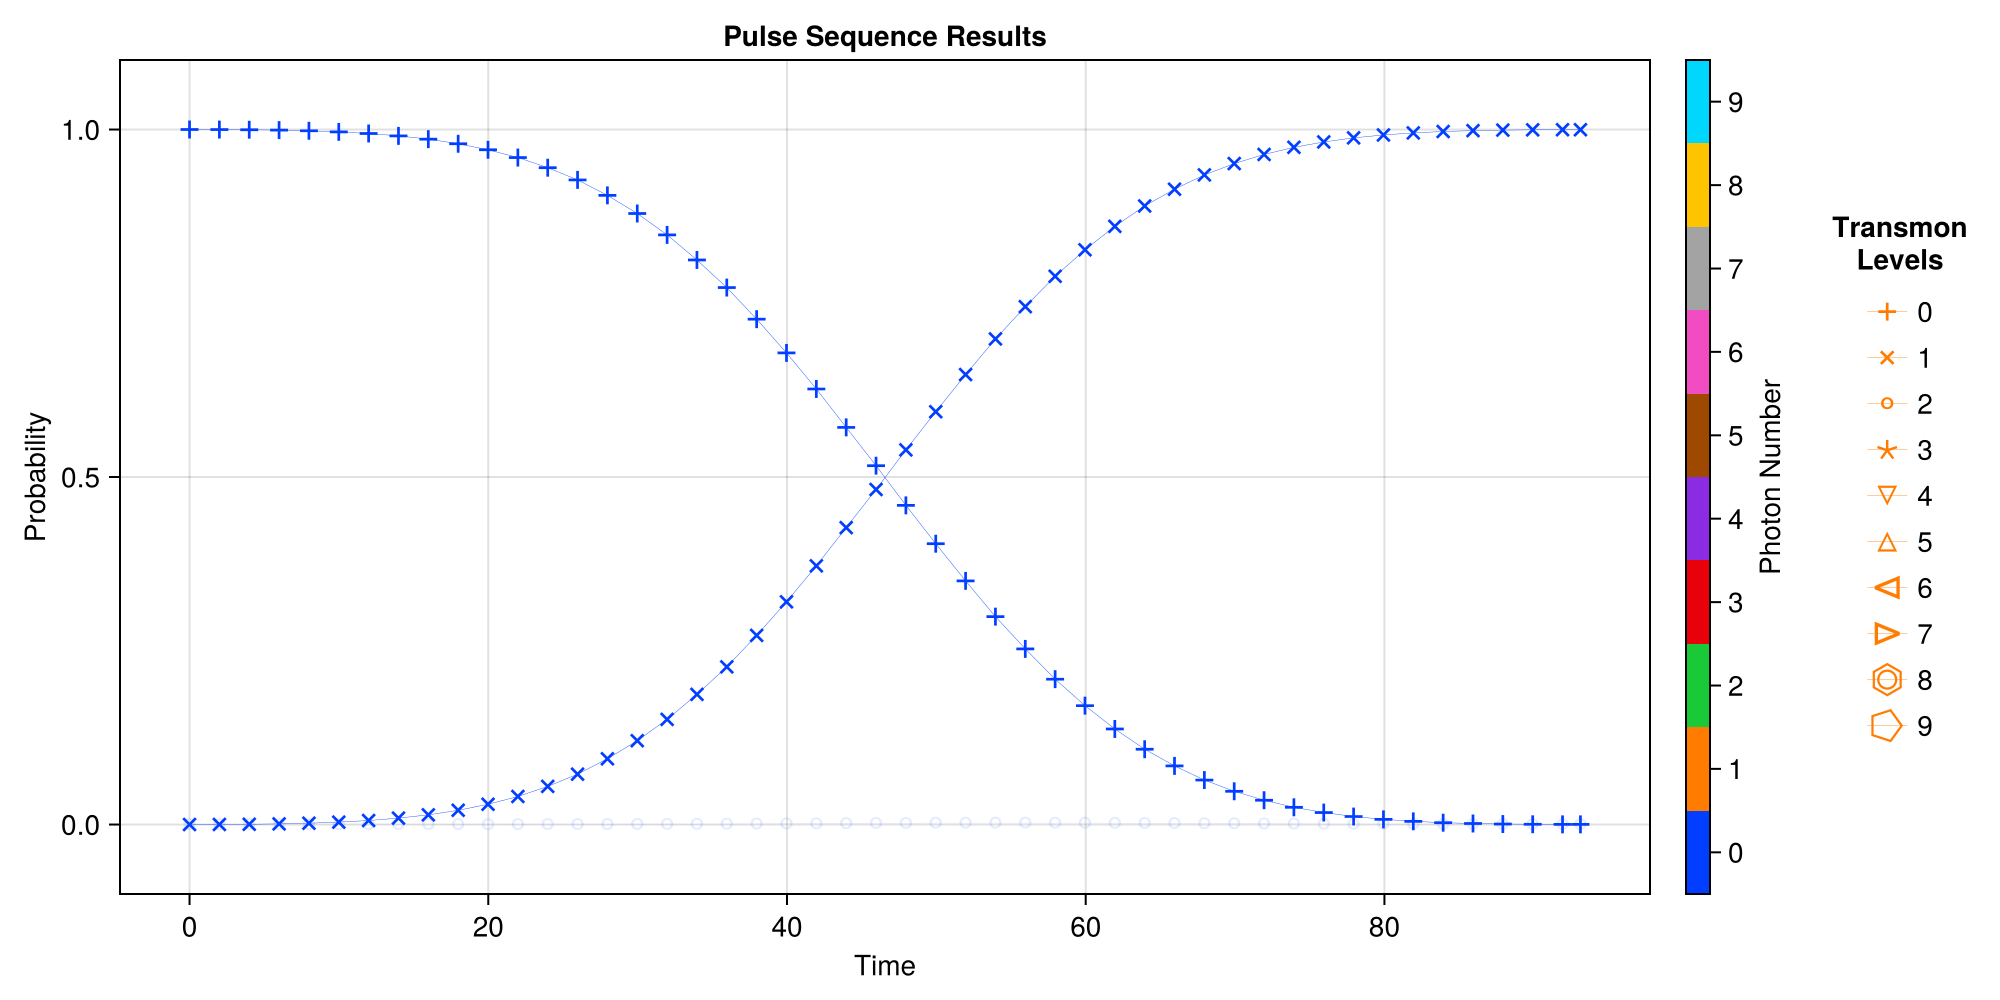

CairoMakie.Screen{IMAGE}


In [18]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge0_res["times"], EVs_ge0, plot_every = 10, emph_states = [(0,0),(1,0)])

In [19]:
println(EVs_ge0[(0,0)][end])
println(EVs_ge0[(1,0)][end])
println(EVs_ge0[(2,0)][end])

0.00023497925721614277 + 5.668968499988827e-20im
0.9997053956676716 - 1.1125226618570478e-17im
5.922036229374779e-5 + 5.357150096839853e-22im


In [20]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997306859885 - 2.1232801079952296e-17im

#### $|0,1\rangle \to |1,1\rangle$

In [21]:
state1 = (0,1)
state2 = (1,1)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge1_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:05:49] Info: On Level 1
[2024-11-08 17:05:49] Info: On Step 1: t = 90.0
[2024-11-08 17:05:49] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 17:05:53] Info: Time Evolution Complete
[2024-11-08 17:05:53] Info: Done with Level_1_step_1
[2024-11-08 17:05:53] Info: Accurace: 0.9971679683013156
[2024-11-08 17:05:53] Info: ------------------------------------------------------------------------------
[2024-11-08 17:05:53] Info: On Step 2: t = 92.5
[2024-11-08 17:05:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 03s (ETA: 0h 00m 00s)
[2024-11-08 17:05:57] Info: Time Evolution Complete
[2024-11-08 17:05:57] Info: Done with Level_1_step_2
[2024-11-08 17:05:57] Info: Accurace: 0.9996341609625029
[2024-11-08 17:05:57] Info: ------------------------------------------------------------------------------
[2024-11-08 17:05:57] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999701
  "freq_d"        => 4.60371

In [22]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_1"] = deepcopy(qubit_ge1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999701
  "freq_d"        => 4.60371

In [23]:
ψ = Mode4.dressed_states[(0,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge1_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:07:09.088
It is being saved at: Data/
[2024-11-08 17:07:09] Info: Running operator q_ge_1
[2024-11-08 17:07:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:07:11] Info: Time Evolution Complete
[2024-11-08 17:07:11] Info: Saving Steps
[2024-11-08 17:07:12] Info: Done with Step_1
[2024-11-08 17:07:12] Info: Done With Running Sequence
[2024-11-08 17:07:12] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [24]:
EVs = SC.Utils.Get_EVs(q_ge1_res["states"], proj_dict);

[2024-11-08 17:07:12] Info: Making Plot


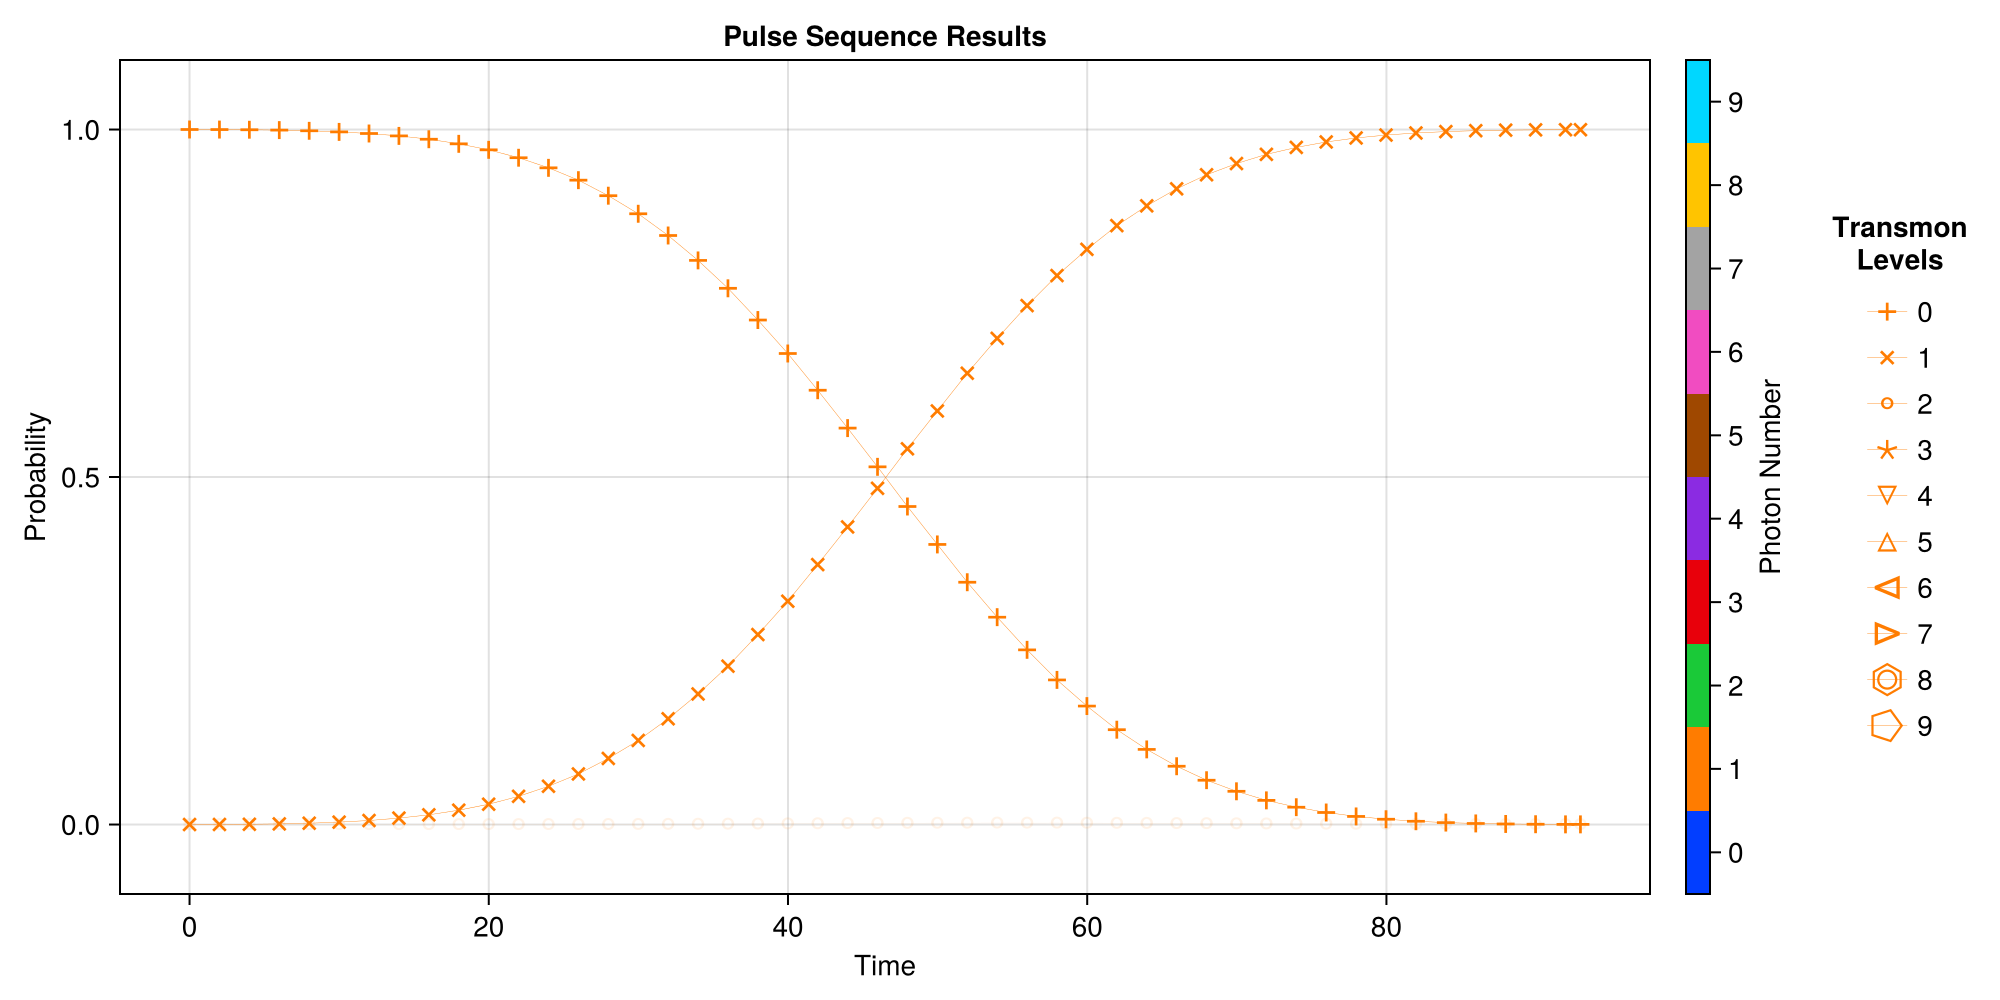

CairoMakie.Screen{IMAGE}


In [25]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge1_res["times"], EVs, plot_every = 10, emph_states = [(0,1),(1,1)])

In [26]:
EVs[(1,1)][end]

0.9997103368648985 - 2.3200570056511994e-17im

In [27]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999976184434806 - 2.324773784448147e-17im

#### $|0,0\rangle+(|1,1\rangle+|0,3\rangle)/\sqrt{2} \to |1,0\rangle+(|0,1\rangle+|1,3\rangle)/\sqrt{2}$

In [28]:

ψ1 = Mode4.dressed_states[(0,0)]+(Mode4.dressed_states[(1,1)]+Mode4.dressed_states[(0,3)])/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode4.dressed_states[(1,0)]+(Mode4.dressed_states[(0,1)]+Mode4.dressed_states[(1,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_g0 = Mode4.dressed_energies[(1,0)]-Mode4.dressed_energies[(0,0)]+ge_stark_shift
freq_d_g1 = Mode4.dressed_energies[(1,1)]-Mode4.dressed_energies[(0,1)]+ge_stark_shift
freq_d_g3 = Mode4.dressed_energies[(1,3)]-Mode4.dressed_energies[(0,3)]+ge_stark_shift

χ = freq_d_g1-freq_d_g0

freq_d = freq_d_g0+4*χ/3

check_op = proj_dict[(1,0)]+proj_dict[(0,1)]+proj_dict[(1,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)


t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge_four_thirds_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)


[2024-11-08 17:07:12] Info: On Level 1
[2024-11-08 17:07:12] Info: On Step 1: t = 90.0
[2024-11-08 17:07:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:07:14] Info: Time Evolution Complete
[2024-11-08 17:07:14] Info: Done with Level_1_step_1
[2024-11-08 17:07:14] Info: Using Check Op
[2024-11-08 17:07:14] Info: Accurace: 0.9961420151377589
[2024-11-08 17:07:14] Info: ------------------------------------------------------------------------------
[2024-11-08 17:07:14] Info: On Step 2: t = 92.5
[2024-11-08 17:07:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:07:15] Info: Time Evolution Complete
[2024-11-08 17:07:15] Info: Done with Level_1_step_2
[2024-11-08 17:07:15] Info: Using Check Op
[2024-11-08 17:07:15] Info: Accurace: 0.9985405988869547
[2024-11-08 17:07:15] Info: ------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998594
  "freq_d"        => 4.60365

In [29]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_4/3"] = deepcopy(qubit_ge_four_thirds_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.998594
  "freq_d"        => 4.60365

In [30]:
ψ = Mode4.dressed_states[(1,1)]+(Mode4.dressed_states[(0,0)]+Mode4.dressed_states[(0,3)])/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ge_four_thirds_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_4/3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:08:03.159
It is being saved at: Data/
[2024-11-08 17:08:03] Info: Running operator q_ge_4/3
[2024-11-08 17:08:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:08:05] Info: Time Evolution Complete
[2024-11-08 17:08:05] Info: Saving Steps
[2024-11-08 17:08:06] Info: Done with Step_1
[2024-11-08 17:08:06] Info: Done With Running Sequence
[2024-11-08 17:08:06] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [31]:
EVs = SC.Utils.Get_EVs(q_ge_four_thirds_res["states"], proj_dict);

[2024-11-08 17:08:06] Info: Making Plot


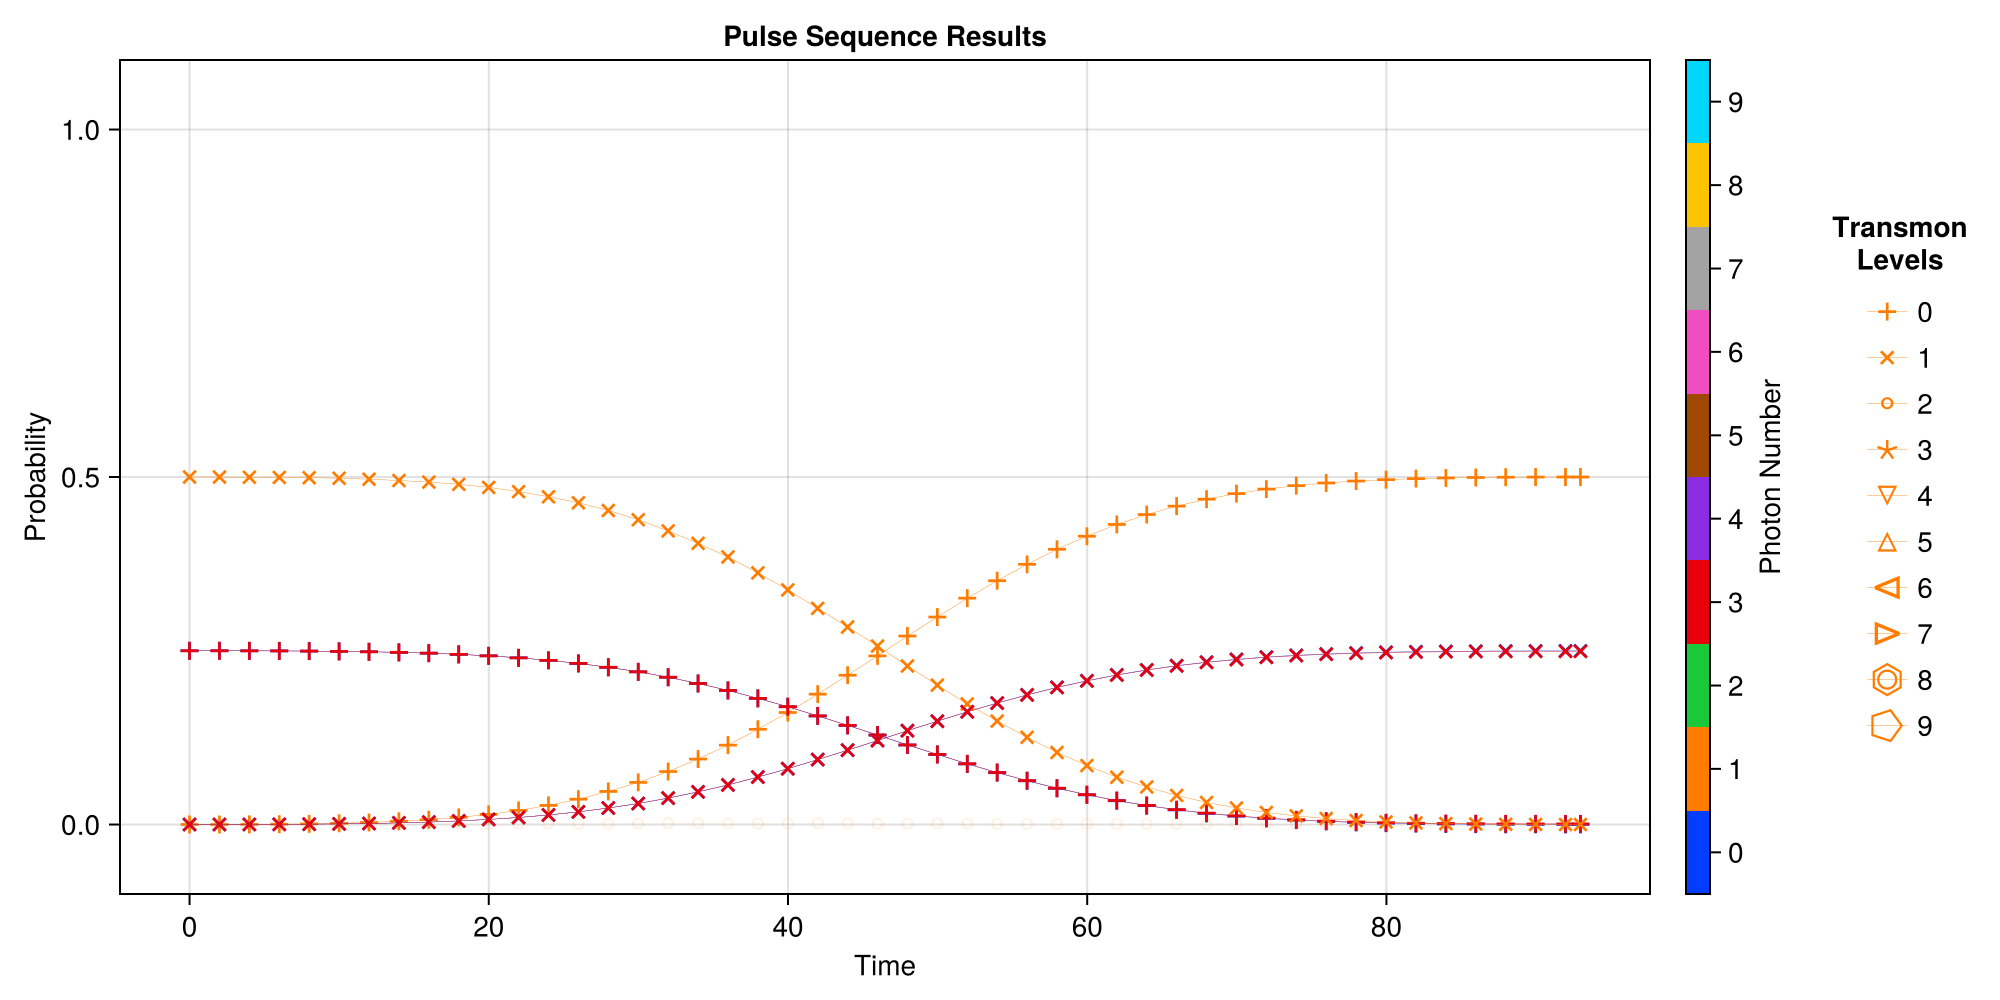

CairoMakie.Screen{IMAGE}


In [32]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge_four_thirds_res["times"], EVs, plot_every = 10, emph_states = [(0,0),(1,0),(0,1),(1,1),(0,3),(1,3)])

In [33]:
println(EVs[(0,1)][end])
println(EVs[(1,0)][end])
println(EVs[(1,3)][end])

0.49995168407276575 + 7.492587400049729e-17im
0.24986778117240374 - 2.5437705488074973e-17im
0.24906484873181697 - 6.444601536795523e-18im


In [34]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999998188659394 + 4.305655659148605e-17im

#### $|0,2\rangle \to |1,2\rangle$

In [35]:
state1 = (0,2)
state2 = (1,2)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge2_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:08:07] Info: On Level 1
[2024-11-08 17:08:07] Info: On Step 1: t = 90.0
[2024-11-08 17:08:07] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:08:09] Info: Time Evolution Complete
[2024-11-08 17:08:09] Info: Done with Level_1_step_1
[2024-11-08 17:08:09] Info: Accurace: 0.9971749452178716
[2024-11-08 17:08:09] Info: ------------------------------------------------------------------------------
[2024-11-08 17:08:09] Info: On Step 2: t = 92.5
[2024-11-08 17:08:09] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:08:11] Info: Time Evolution Complete
[2024-11-08 17:08:11] Info: Done with Level_1_step_2
[2024-11-08 17:08:11] Info: Accurace: 0.99964519435546
[2024-11-08 17:08:11] Info: ------------------------------------------------------------------------------
[2024-11-08 17:08:11] Info: On St

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60352

In [36]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_2"] = deepcopy(qubit_ge2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60352

In [37]:
ψ = Mode4.dressed_states[(0, 2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge2_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:08:56.596
It is being saved at: Data/
[2024-11-08 17:08:56] Info: Running operator q_ge_2
[2024-11-08 17:08:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:08:58] Info: Time Evolution Complete
[2024-11-08 17:08:58] Info: Saving Steps
[2024-11-08 17:08:59] Info: Done with Step_1
[2024-11-08 17:08:59] Info: Done With Running Sequence
[2024-11-08 17:08:59] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [38]:
EVs = SC.Utils.Get_EVs(q_ge2_res["states"], proj_dict);

[2024-11-08 17:08:59] Info: Making Plot


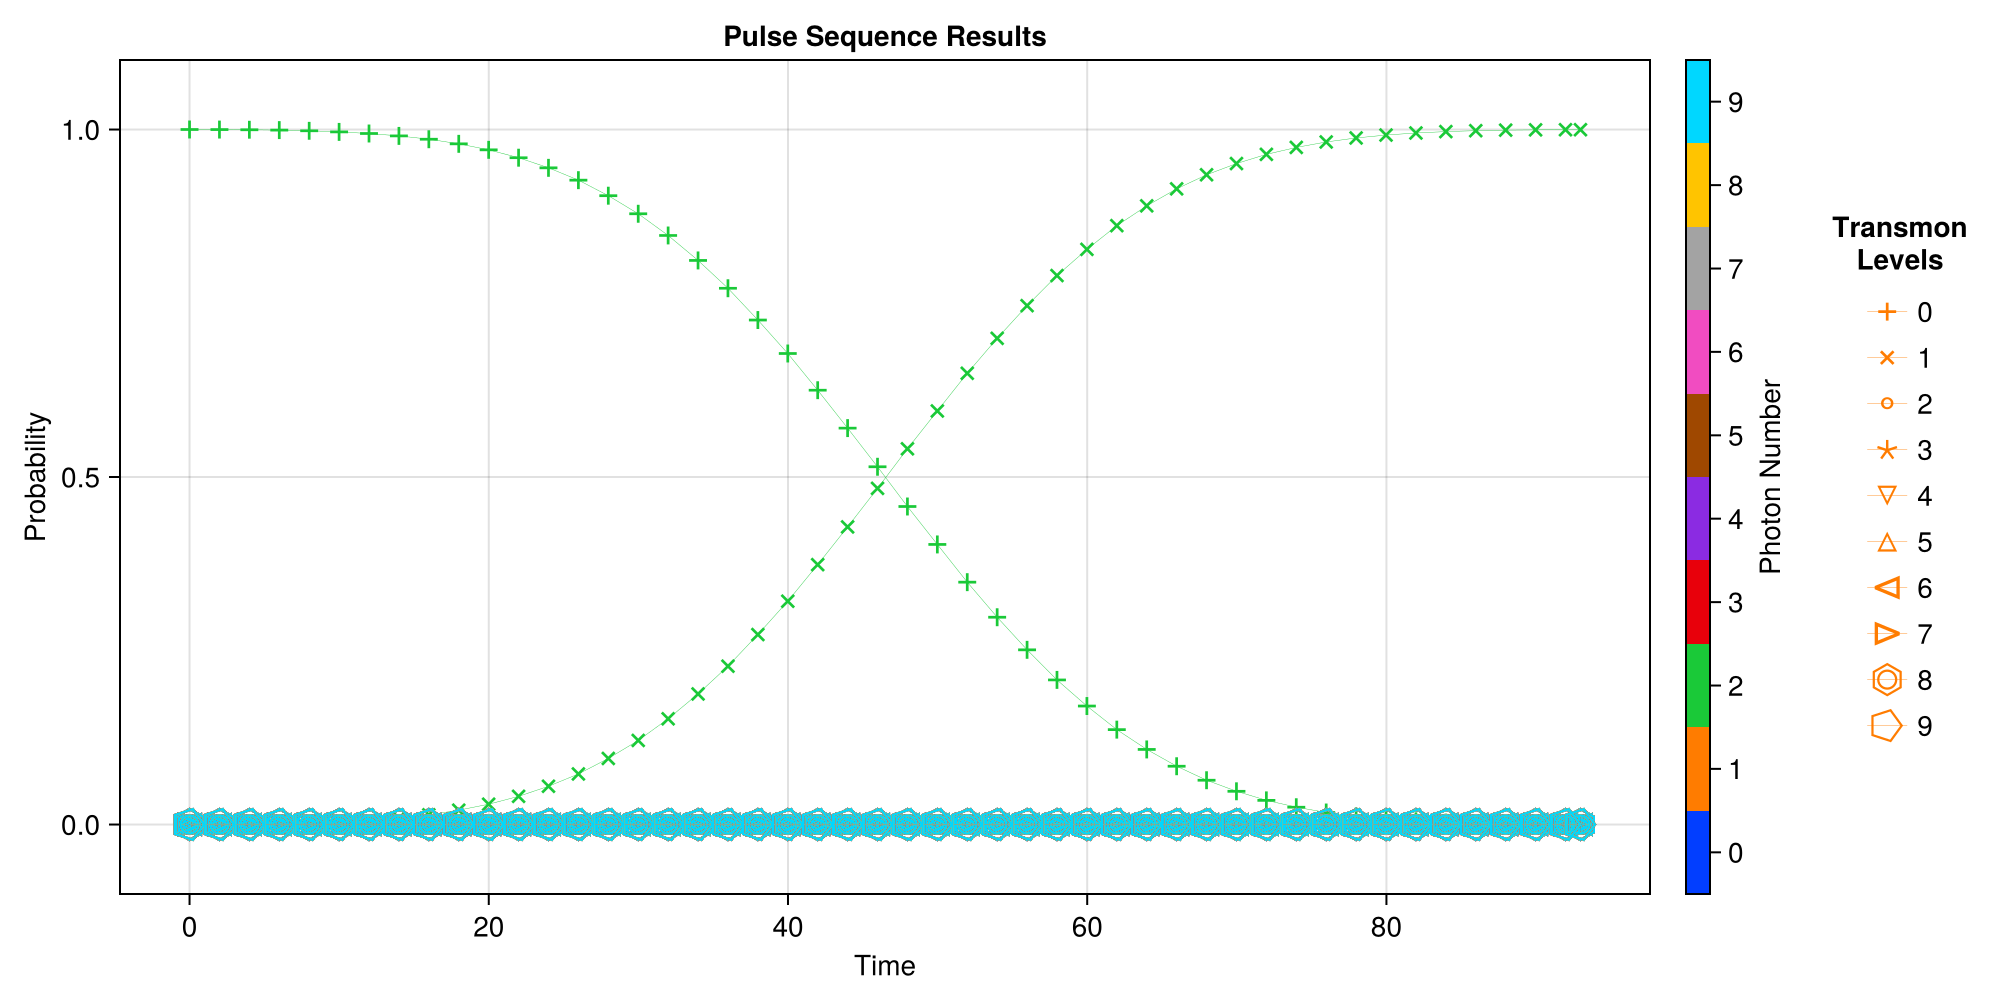

CairoMakie.Screen{IMAGE}


In [39]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge2_res["times"], EVs, plot_every = 10)

In [40]:
EVs[(1,2)][end]

0.9997127480933756 - 1.2472097030855558e-16im

In [41]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999153621374 - 1.2439772272508896e-16im

#### $|0,3\rangle \to |1,3\rangle$

In [42]:
state1 = (0,3)
state2 = (1,3)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ge_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ge3_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ge_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:09:00] Info: On Level 1
[2024-11-08 17:09:00] Info: On Step 1: t = 90.0
[2024-11-08 17:09:00] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:09:01] Info: Time Evolution Complete
[2024-11-08 17:09:01] Info: Done with Level_1_step_1
[2024-11-08 17:09:01] Info: Accurace: 0.9971702453189905
[2024-11-08 17:09:01] Info: ------------------------------------------------------------------------------
[2024-11-08 17:09:01] Info: On Step 2: t = 92.5
[2024-11-08 17:09:01] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:09:03] Info: Time Evolution Complete
[2024-11-08 17:09:03] Info: Done with Level_1_step_2
[2024-11-08 17:09:03] Info: Accurace: 0.9996445875112329
[2024-11-08 17:09:03] Info: ------------------------------------------------------------------------------
[2024-11-08 17:09:03] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60332

In [43]:
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ge_3"] = deepcopy(qubit_ge3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00538
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999713
  "freq_d"        => 4.60332

In [44]:
ψ = Mode4.dressed_states[(0, 3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ge3_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ge_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:09:55.101
It is being saved at: Data/
[2024-11-08 17:09:55] Info: Running operator q_ge_3
[2024-11-08 17:09:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:09:57] Info: Time Evolution Complete
[2024-11-08 17:09:57] Info: Saving Steps
[2024-11-08 17:09:58] Info: Done with Step_1
[2024-11-08 17:09:58] Info: Done With Running Sequence
[2024-11-08 17:09:58] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [45]:
EVs = SC.Utils.Get_EVs(q_ge3_res["states"], proj_dict);

[2024-11-08 17:09:58] Info: Making Plot


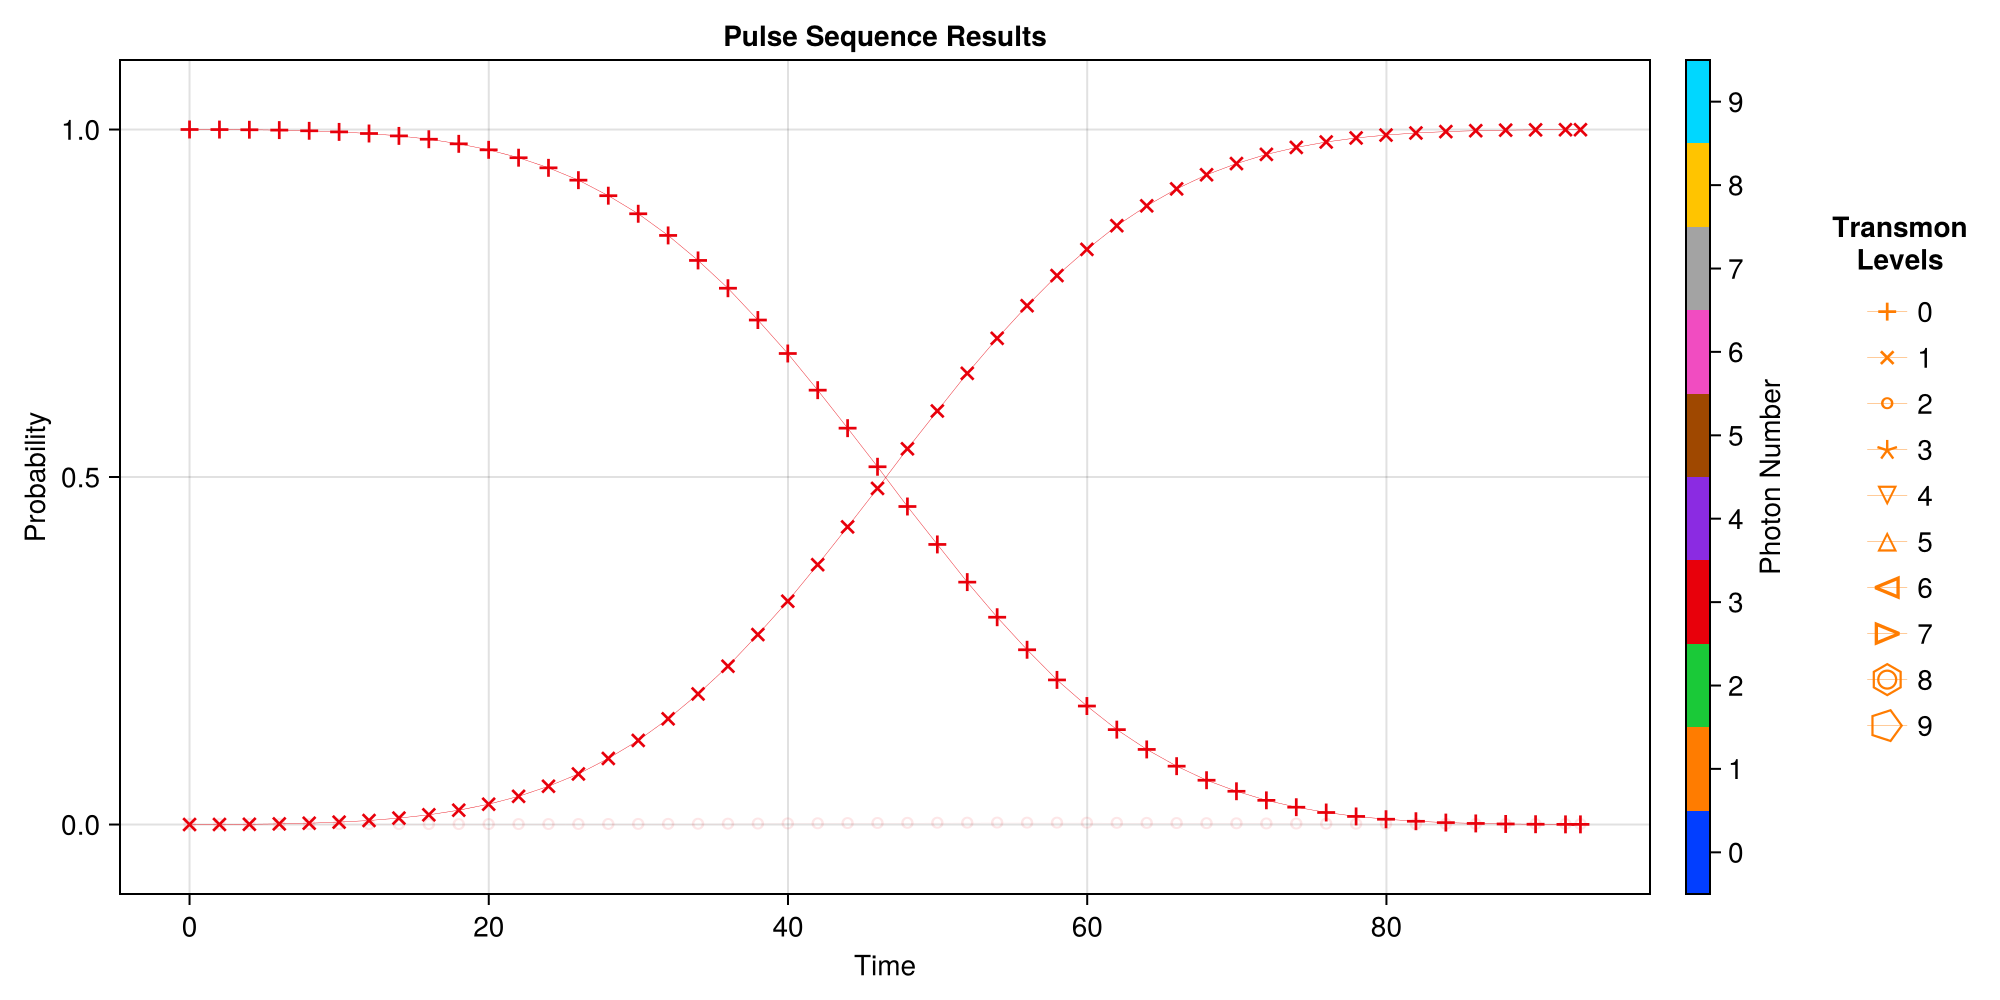

CairoMakie.Screen{IMAGE}


In [46]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ge3_res["times"], EVs, plot_every = 10, emph_states = [(0,3),(1,3)])

In [47]:
EVs[(1,3)][end]

0.9997129125671648 - 1.446378109458522e-16im

In [48]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999959033407 - 1.4248052258766944e-16im

### Guassian e -> f

In [49]:
println("Target σ: "*string(device_config["device"]["soc"]["qubit"]["pulses"]["pi_ef"]["sigma"]))

Target σ: 0.023251488095238096


##### Getting Stark Shift

[2024-11-08 17:09:58] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:04


[2024-11-08 17:10:03] Info: Done With Floquet Sweep
[2024-11-08 17:10:03] Info: Fit Stuff: 3-element Vector{Float64}:	 0.00016526383865330608	 0.008956477104735388	 2.0062855986469663
Stark shift res: [0.00016526383865330608, 55.650622184490636]


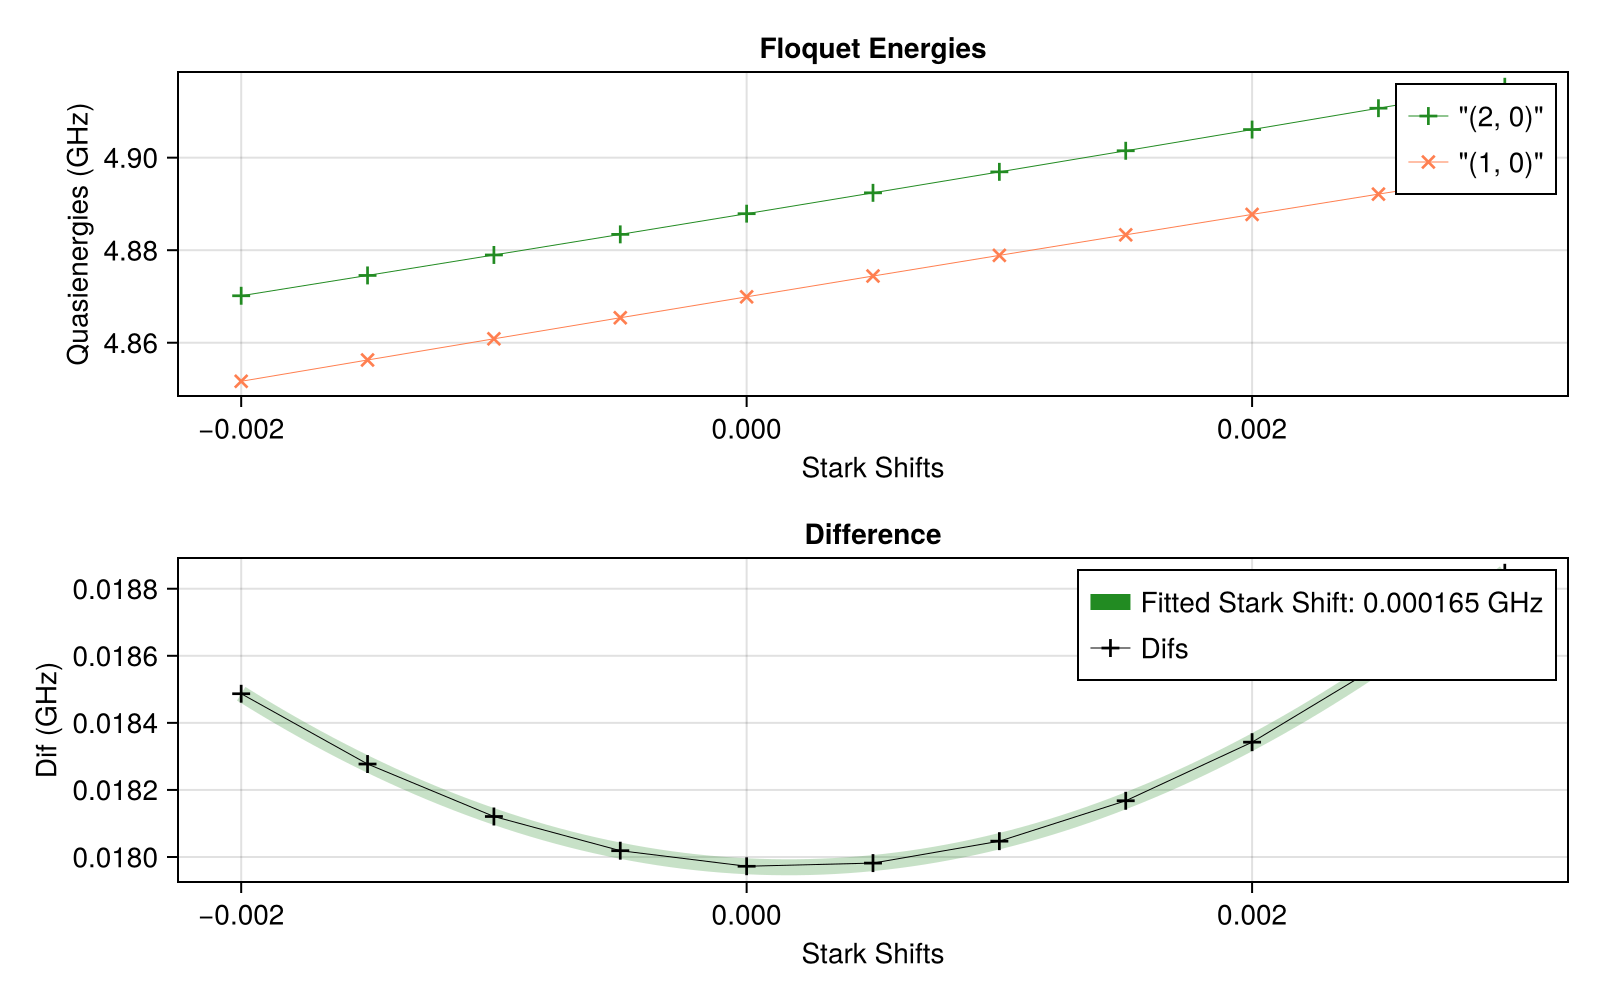

In [50]:
ef_ε = 0.00385
drive_op = Mode4.n̂ₜ
state1 = (1,0)
state2 = (2,0)

stark_shift_list = collect(LinRange(-0.002, 0.003, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode4, state1, state2, ef_ε, stark_shift_list)
println("Stark shift res: "*string(stark_shift_res))

ef_stark_shift = stark_shift_res[1];

##### $|1,0\rangle \to |2,0\rangle$

In [51]:
state1 = (1,0)
state2 = (2,0)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1] + ef_stark_shift


envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef0_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:10:03] Info: On Level 1
[2024-11-08 17:10:03] Info: On Step 1: t = 90.0
[2024-11-08 17:10:03] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:10:05] Info: Time Evolution Complete
[2024-11-08 17:10:05] Info: Done with Level_1_step_1
[2024-11-08 17:10:05] Info: Accurace: 0.9973161650125466
[2024-11-08 17:10:05] Info: ------------------------------------------------------------------------------
[2024-11-08 17:10:05] Info: On Step 2: t = 92.5
[2024-11-08 17:10:05] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:10:06] Info: Time Evolution Complete
[2024-11-08 17:10:06] Info: Done with Level_1_step_2
[2024-11-08 17:10:06] Info: Accurace: 0.9997884700280996
[2024-11-08 17:10:06] Info: ------------------------------------------------------------------------------
[2024-11-08 17:10:06] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999853
  "freq_d"        => 4.49548

In [52]:
#Mode4.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ef_0"] = deepcopy(qubit_ef0_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999853
  "freq_d"        => 4.49548

In [53]:
ψ = Mode4.dressed_states[(1,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef0_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ef_0"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:10:52.883
It is being saved at: Data/
[2024-11-08 17:10:52] Info: Running operator q_ef_0
[2024-11-08 17:10:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:10:54] Info: Time Evolution Complete
[2024-11-08 17:10:54] Info: Saving Steps
[2024-11-08 17:10:55] Info: Done with Step_1
[2024-11-08 17:10:55] Info: Done With Running Sequence
[2024-11-08 17:10:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [54]:
EVs_ef0 = SC.Utils.Get_EVs(q_ef0_res["states"], proj_dict);

[2024-11-08 17:10:55] Info: Making Plot


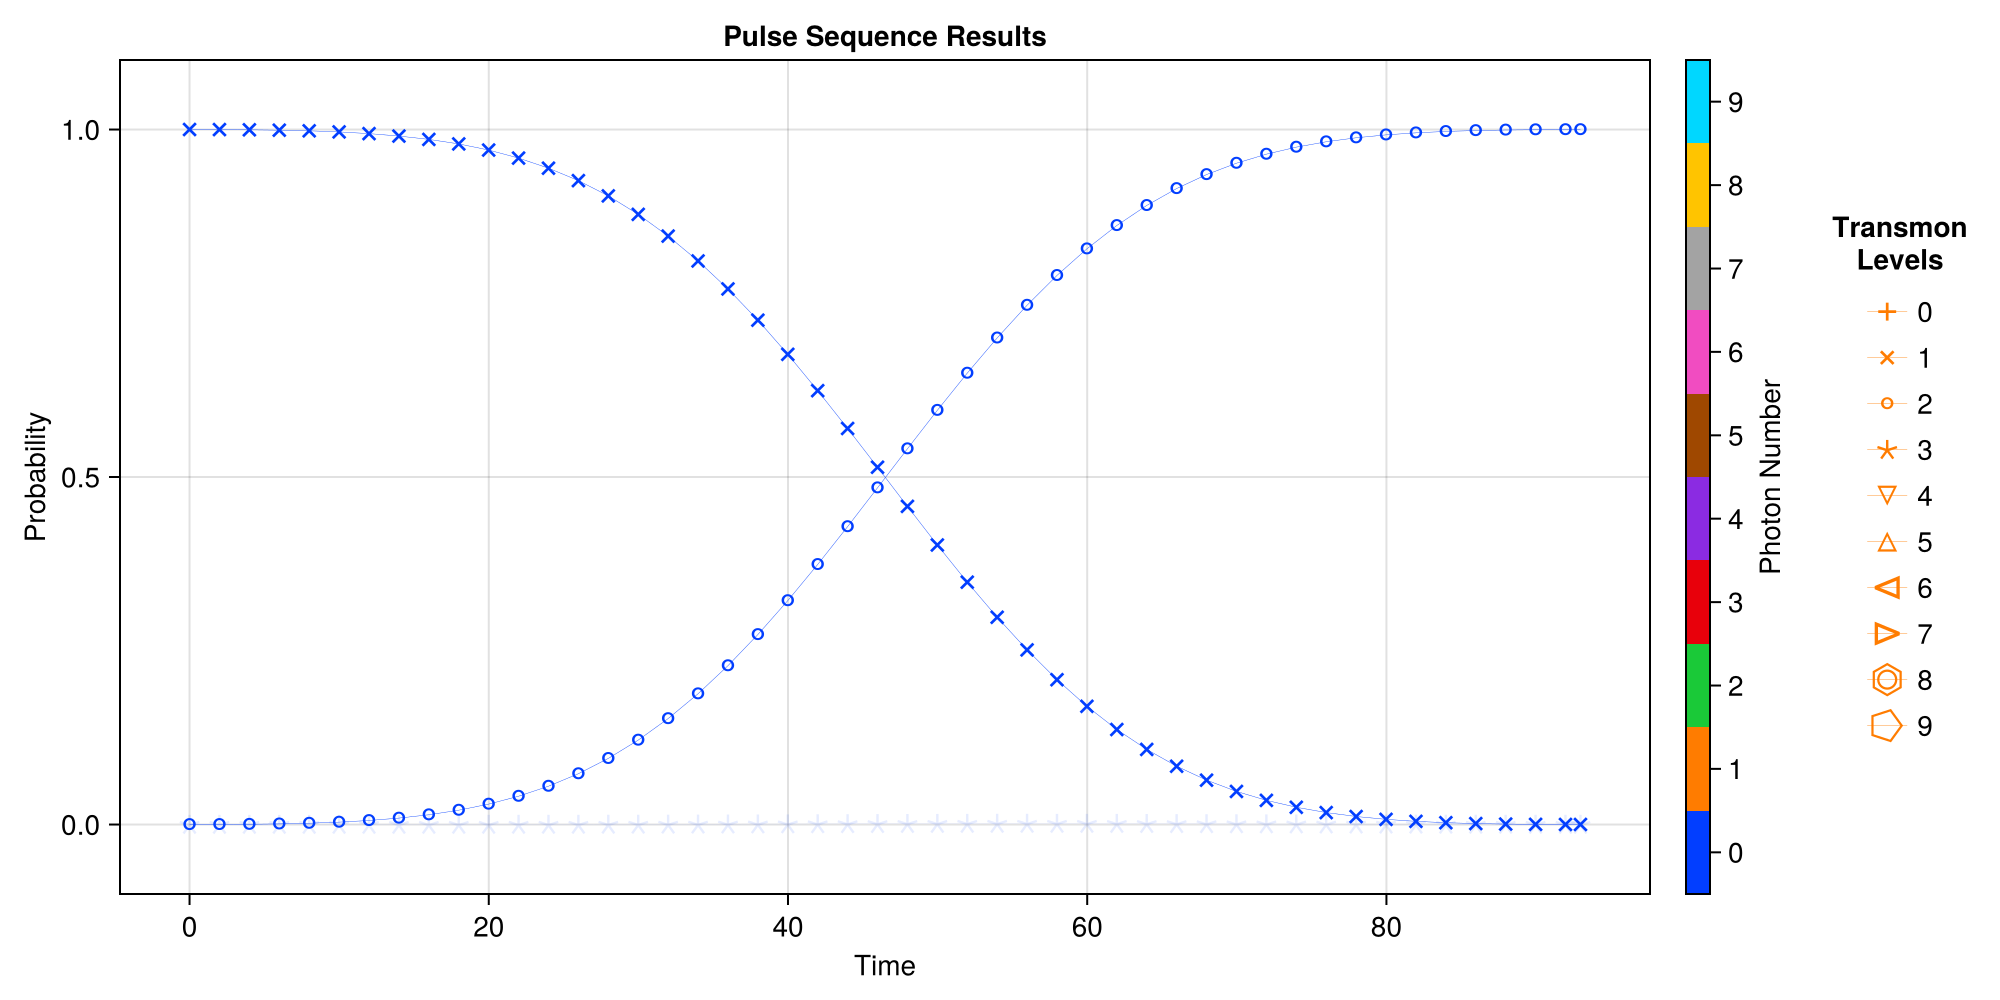

CairoMakie.Screen{IMAGE}


In [55]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ef0_res["times"], EVs_ef0, plot_every = 10, emph_states = [(1,0),(2,0)])

In [56]:
println(EVs_ef0[(0,0)][end])
println(EVs_ef0[(1,0)][end])
println(EVs_ef0[(2,0)][end])
println(EVs_ef0[(3,0)][end])

1.5789575713814777e-5 - 7.78709648150128e-23im
4.6951181996403745e-5 + 8.085968448766965e-21im
0.9998917440547715 - 2.3910106050635518e-17im
4.2813336321110384e-5 + 1.0470179523715734e-21im


In [57]:
tot = 0
for key in keys(EVs_ef0)
    tot+=EVs_ef0[key][end]
end
print(tot)

0.9999972984349104 - 2.4039281345813596e-17im

##### $|1,1\rangle \to |2,1\rangle$

In [58]:
state1 = (1,1)
state2 = (2,1)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef1_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:10:56] Info: On Level 1
[2024-11-08 17:10:56] Info: On Step 1: t = 90.0
[2024-11-08 17:10:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:10:57] Info: Time Evolution Complete
[2024-11-08 17:10:57] Info: Done with Level_1_step_1
[2024-11-08 17:10:57] Info: Accurace: 0.9973537519337881
[2024-11-08 17:10:57] Info: ------------------------------------------------------------------------------
[2024-11-08 17:10:57] Info: On Step 2: t = 92.5
[2024-11-08 17:10:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:10:59] Info: Time Evolution Complete
[2024-11-08 17:10:59] Info: Done with Level_1_step_2
[2024-11-08 17:10:59] Info: Accurace: 0.999828753279561
[2024-11-08 17:10:59] Info: ------------------------------------------------------------------------------
[2024-11-08 17:10:59] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.4953

In [59]:
#Mode4.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ef_1"] = deepcopy(qubit_ef1_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.4953

In [60]:
ψ = Mode4.dressed_states[(1,1)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef1_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ef_1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:11:42.502
It is being saved at: Data/
[2024-11-08 17:11:42] Info: Running operator q_ef_1
[2024-11-08 17:11:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:11:44] Info: Time Evolution Complete
[2024-11-08 17:11:44] Info: Saving Steps
[2024-11-08 17:11:44] Info: Done with Step_1
[2024-11-08 17:11:44] Info: Done With Running Sequence
[2024-11-08 17:11:44] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [61]:
EVs = SC.Utils.Get_EVs(q_ef1_res["states"], proj_dict);

[2024-11-08 17:11:45] Info: Making Plot


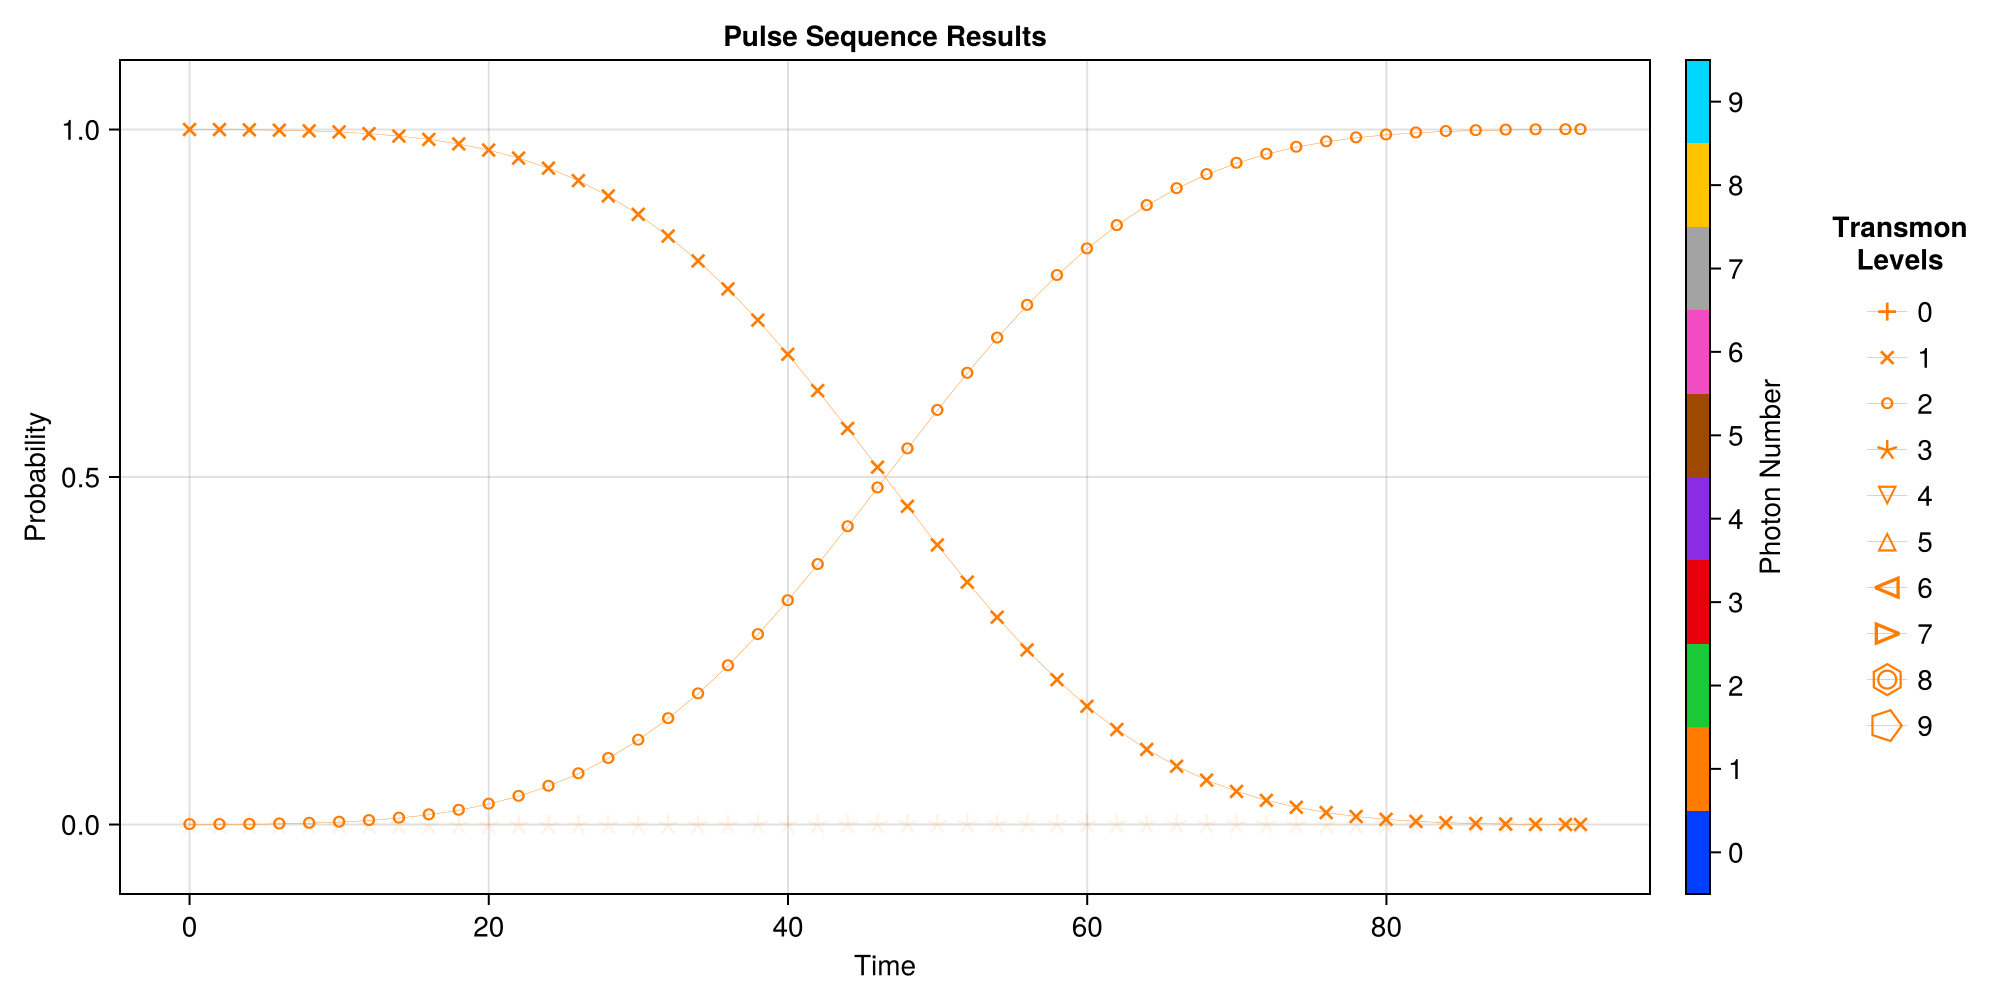

CairoMakie.Screen{IMAGE}


In [62]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ef1_res["times"], EVs, plot_every = 10, emph_states = [(1,1),(2,1)])

In [63]:
EVs[(2,1)][end]

0.9998939551818822 + 3.104563178294399e-17im

In [64]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999994809735424 + 3.0324178864950166e-17im

##### $|1,0\rangle+\frac{1}{\sqrt{2}}\left(|2,0\rangle + |1, 3\rangle\right)\to |2,0\rangle+\frac{1}{\sqrt{2}}\left(|1,0\rangle + |2, 3\rangle\right)$

In [65]:
ψ1 = Mode4.dressed_states[(1,0)]/sqrt(2)+Mode4.dressed_states[(2,0)]+Mode4.dressed_states[(1,3)]/sqrt(2)
ψ1 = ψ1/qt.norm(ψ1)

ψ2 = Mode4.dressed_states[(2,0)]+(Mode4.dressed_states[(1,0)]+Mode4.dressed_states[(2,3)])/sqrt(2)
ψ2 = ψ2/qt.norm(ψ2)

freq_d_ef0 = Mode4.dressed_energies[(2,0)]-Mode4.dressed_energies[(1,0)]+ef_stark_shift
freq_d_ef1 = Mode4.dressed_energies[(2,1)]-Mode4.dressed_energies[(1,1)]+ef_stark_shift
freq_d_ef3 = Mode4.dressed_energies[(2,3)]-Mode4.dressed_energies[(1,3)]+ef_stark_shift

χ = freq_d_ef1-freq_d_ef0

freq_d = freq_d_ef0+3*χ/2

check_op = proj_dict[(2,0)]+proj_dict[(1,0)]+proj_dict[(2,3)]

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]
envelope_params = Dict{Any, Any}("sigma_factor" => 4)
qubit_ef_three_halves_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5, check_op = check_op)

[2024-11-08 17:11:45] Info: On Level 1
[2024-11-08 17:11:45] Info: On Step 1: t = 90.0
[2024-11-08 17:11:45] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:11:47] Info: Time Evolution Complete
[2024-11-08 17:11:47] Info: Done with Level_1_step_1
[2024-11-08 17:11:47] Info: Using Check Op
[2024-11-08 17:11:47] Info: Accurace: 0.9988177704257262
[2024-11-08 17:11:47] Info: ------------------------------------------------------------------------------
[2024-11-08 17:11:47] Info: On Step 2: t = 92.5
[2024-11-08 17:11:47] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:11:49] Info: Time Evolution Complete
[2024-11-08 17:11:49] Info: Done with Level_1_step_2
[2024-11-08 17:11:49] Info: Using Check Op
[2024-11-08 17:11:49] Info: Accurace: 0.999464834829412
[2024-11-08 17:11:49] Info: -------------------------

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999484
  "freq_d"        => 4.49521

In [66]:
#Mode4.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ef_3/2"] = deepcopy(qubit_ef_three_halves_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999484
  "freq_d"        => 4.49521

In [67]:
ψ = Mode4.dressed_states[(1,0)]/sqrt(2)+Mode4.dressed_states[(2,0)]+Mode4.dressed_states[(1,3)]/sqrt(2)
ψ = ψ/qt.norm(ψ)
solver_kwargs = Dict{Any, Any}("abstol" => 1e-9, "reltol" => 1e-9)
q_ef_three_halves_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ef_3/2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:12:38.504
It is being saved at: Data/
[2024-11-08 17:12:38] Info: Running operator q_ef_3/2
[2024-11-08 17:12:38] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:12:40] Info: Time Evolution Complete
[2024-11-08 17:12:41] Info: Saving Steps
[2024-11-08 17:12:41] Info: Done with Step_1
[2024-11-08 17:12:41] Info: Done With Running Sequence
[2024-11-08 17:12:41] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [68]:
EVs = SC.Utils.Get_EVs(q_ef_three_halves_res["states"], proj_dict);

[2024-11-08 17:12:41] Info: Making Plot


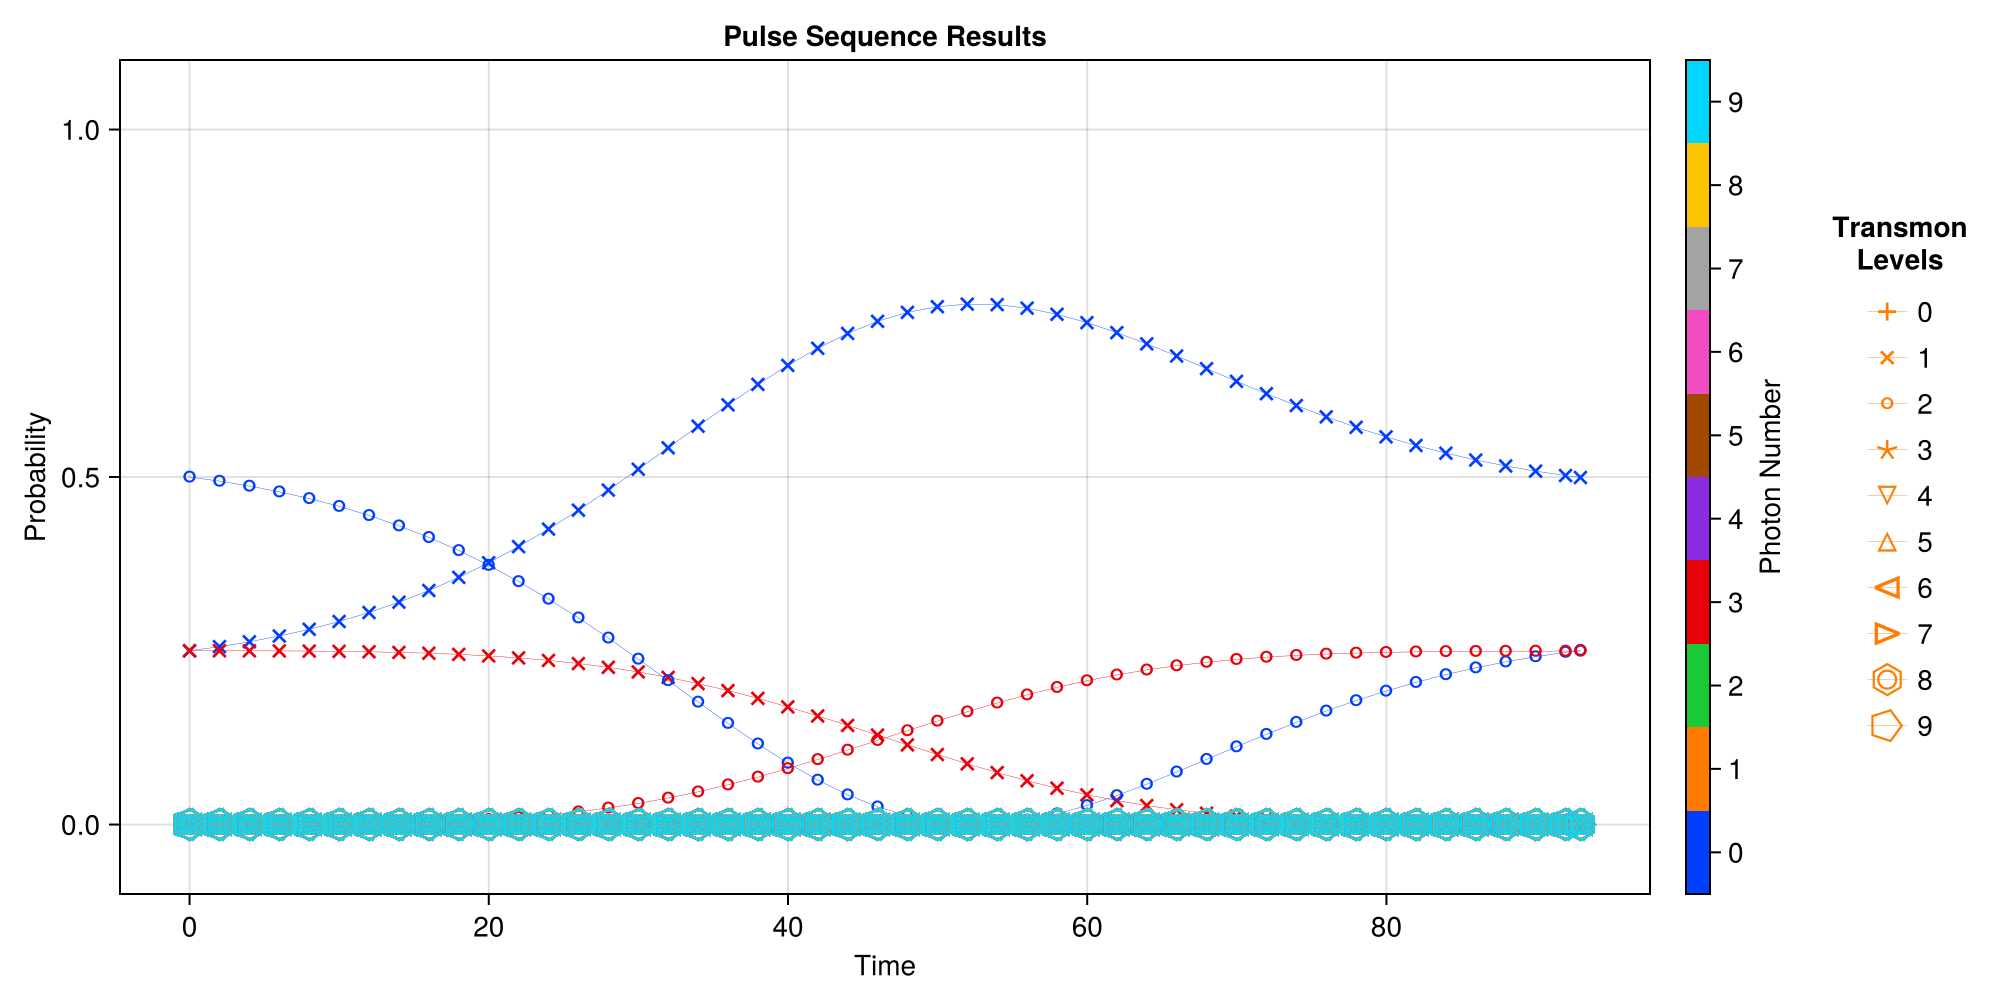

CairoMakie.Screen{IMAGE}


In [69]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ef_three_halves_res["times"], EVs, plot_every = 10)

In [70]:
println(EVs[(2,0)][end])
println(EVs[(1,0)][end])
println(EVs[(2,3)][end])

0.2507135555214835 + 2.6024491019447543e-17im
0.4992793085628995 - 1.596104081357821e-17im
0.24951045252971057 - 4.039815478360546e-21im


In [71]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999997211125282 + 1.0133901673485603e-17im

##### $|1,2\rangle \to |2,2\rangle$

In [72]:
state1 = (1,2)
state2 = (2,2)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 100]

qubit_ef2_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 7)


[2024-11-08 17:12:42] Info: On Level 1
[2024-11-08 17:12:42] Info: On Step 1: t = 90.0
[2024-11-08 17:12:42] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:12:43] Info: Time Evolution Complete
[2024-11-08 17:12:43] Info: Done with Level_1_step_1
[2024-11-08 17:12:43] Info: Accurace: 0.9973514354307556
[2024-11-08 17:12:43] Info: ------------------------------------------------------------------------------
[2024-11-08 17:12:43] Info: On Step 2: t = 92.5
[2024-11-08 17:12:43] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:12:46] Info: Time Evolution Complete
[2024-11-08 17:12:46] Info: Done with Level_1_step_2
[2024-11-08 17:12:46] Info: Accurace: 0.9998285491241539
[2024-11-08 17:12:46] Info: ------------------------------------------------------------------------------
[2024-11-08 17:12:46] Info: On 

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49512

In [73]:
#Mode4.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ef_2"] = deepcopy(qubit_ef2_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 92.9688
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2422, "mu"=>46.4844)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999894
  "freq_d"        => 4.49512

In [74]:
ψ = Mode4.dressed_states[(1,2)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef2_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ef_2"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:13:53.275
It is being saved at: Data/
[2024-11-08 17:13:53] Info: Running operator q_ef_2
[2024-11-08 17:13:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:13:55] Info: Time Evolution Complete
[2024-11-08 17:13:55] Info: Saving Steps
[2024-11-08 17:13:55] Info: Done with Step_1
[2024-11-08 17:13:55] Info: Done With Running Sequence
[2024-11-08 17:13:55] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199933, 0.399866, 0.599798, 0.799731, 0.999664, 1.1996…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [75]:
EVs = SC.Utils.Get_EVs(q_ef2_res["states"], proj_dict);

[2024-11-08 17:13:55] Info: Making Plot


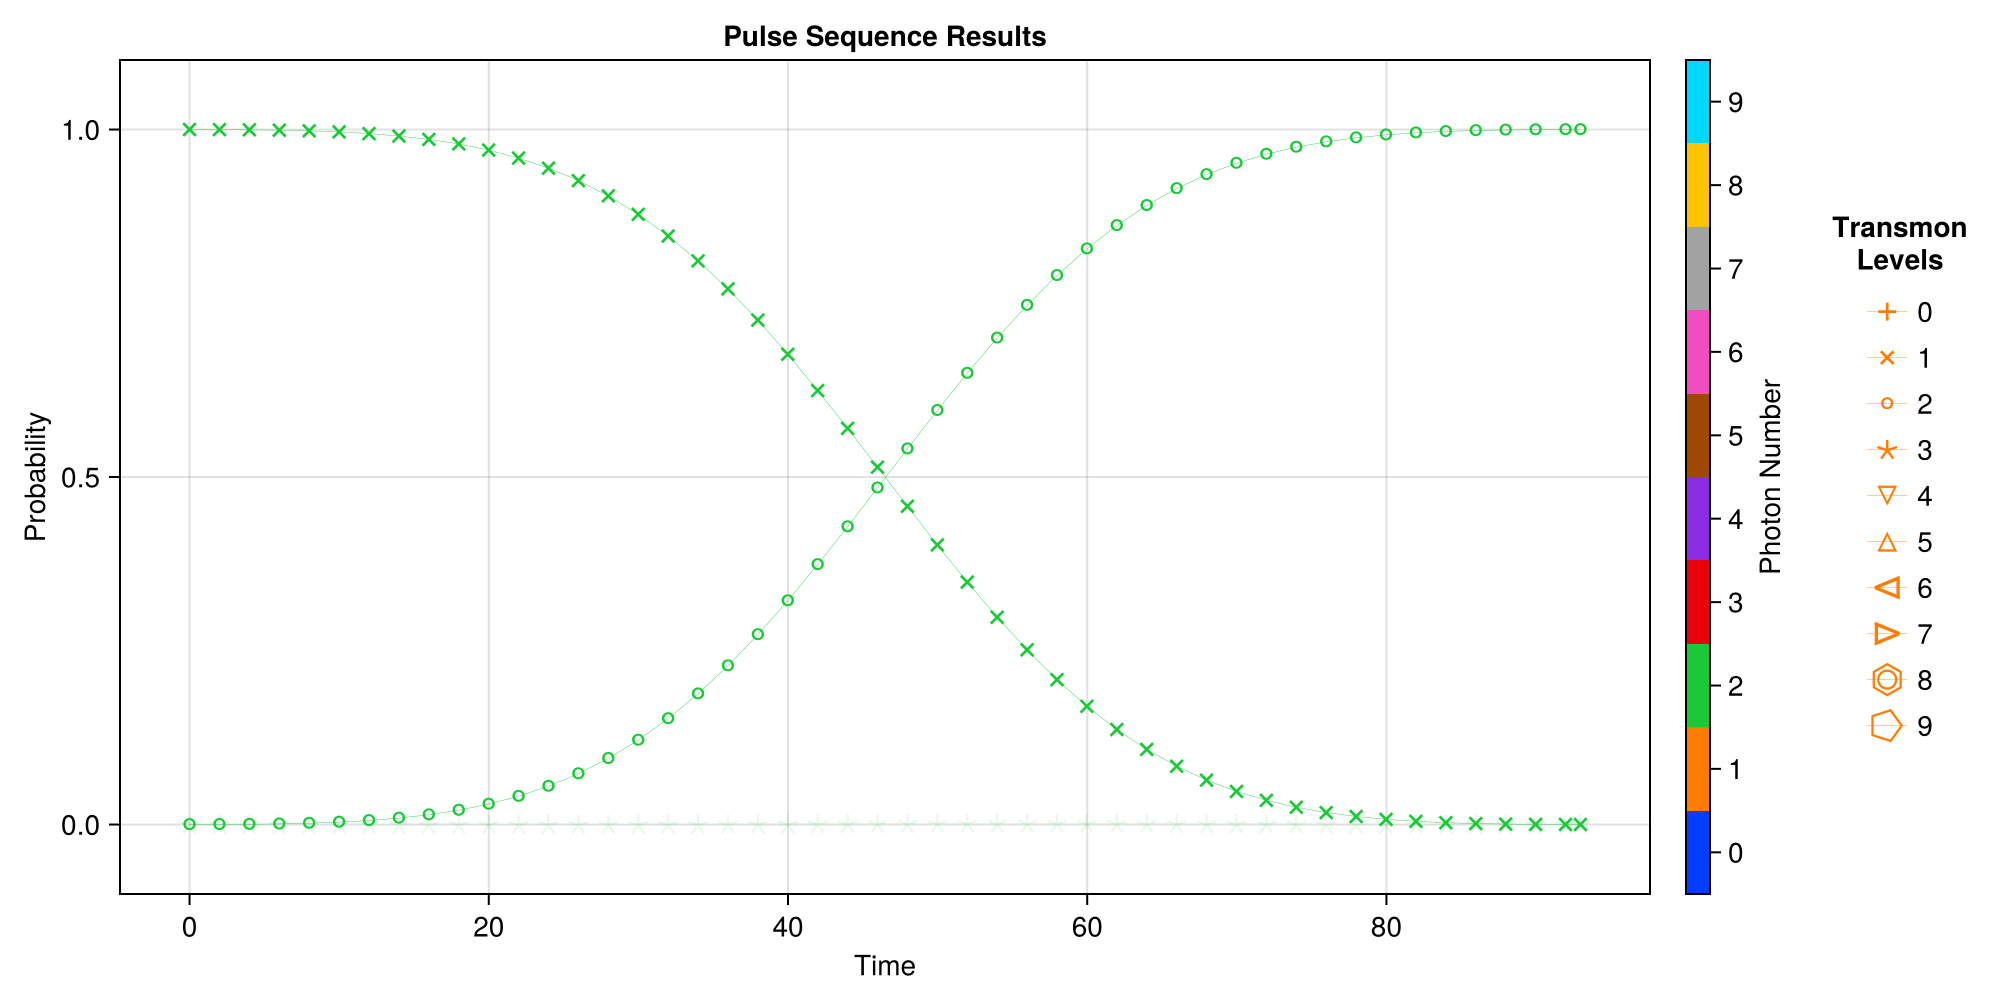

CairoMakie.Screen{IMAGE}


In [76]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ef2_res["times"], EVs, plot_every = 10, emph_states = [(1,2),(2,2)])

In [77]:
EVs[(2,2)][end]

0.9998944950785722 - 1.458106382519134e-17im

In [78]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
print(tot)

0.9999999950496532 - 1.487634104776912e-17im

##### $|1,3\rangle \to |2,3\rangle$

In [79]:
state1 = (1,3)
state2 = (2,3)
ψ1 = Mode4.dressed_states[state1]
ψ2 = Mode4.dressed_states[state2]

freq_d = Mode4.dressed_energies[state2]-Mode4.dressed_energies[state1]+ef_stark_shift

envelope = "Guassian"
envelope_args = Dict{Any, Any}("sigma" => 1, "mu"=>1)

t_range = [90, 110]

qubit_ef3_opt_res = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ef_ε, freq_d, 0, t_range, envelope, envelope_args, levels = 5)


[2024-11-08 17:13:56] Info: On Level 1
[2024-11-08 17:13:56] Info: On Step 1: t = 90.0
[2024-11-08 17:13:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:13:57] Info: Time Evolution Complete
[2024-11-08 17:13:57] Info: Done with Level_1_step_1
[2024-11-08 17:13:57] Info: Accurace: 0.9973487716171738
[2024-11-08 17:13:57] Info: ------------------------------------------------------------------------------
[2024-11-08 17:13:57] Info: On Step 2: t = 95.0
[2024-11-08 17:13:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:13:59] Info: Time Evolution Complete
[2024-11-08 17:13:59] Info: Done with Level_1_step_2
[2024-11-08 17:13:59] Info: Accurace: 0.998738004276674
[2024-11-08 17:13:59] Info: ------------------------------------------------------------------------------
[2024-11-08 17:13:59] Info: On S

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49495

In [80]:
#Mode4.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_ef_3"] = deepcopy(qubit_ef3_opt_res)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00385
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999889
  "freq_d"        => 4.49495

In [81]:
ψ = Mode4.dressed_states[(1,3)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
q_ef3_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_ef_3"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T17:14:48.946
It is being saved at: Data/
[2024-11-08 17:14:48] Info: Running operator q_ef_3
[2024-11-08 17:14:48] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 02s (ETA: 0h 00m 00s)
[2024-11-08 17:14:51] Info: Time Evolution Complete
[2024-11-08 17:14:51] Info: Saving Steps
[2024-11-08 17:14:51] Info: Done with Step_1
[2024-11-08 17:14:51] Info: Done With Running Sequence
[2024-11-08 17:14:51] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [82]:
EVs = SC.Utils.Get_EVs(q_ef3_res["states"], proj_dict);

[2024-11-08 17:14:52] Info: Making Plot


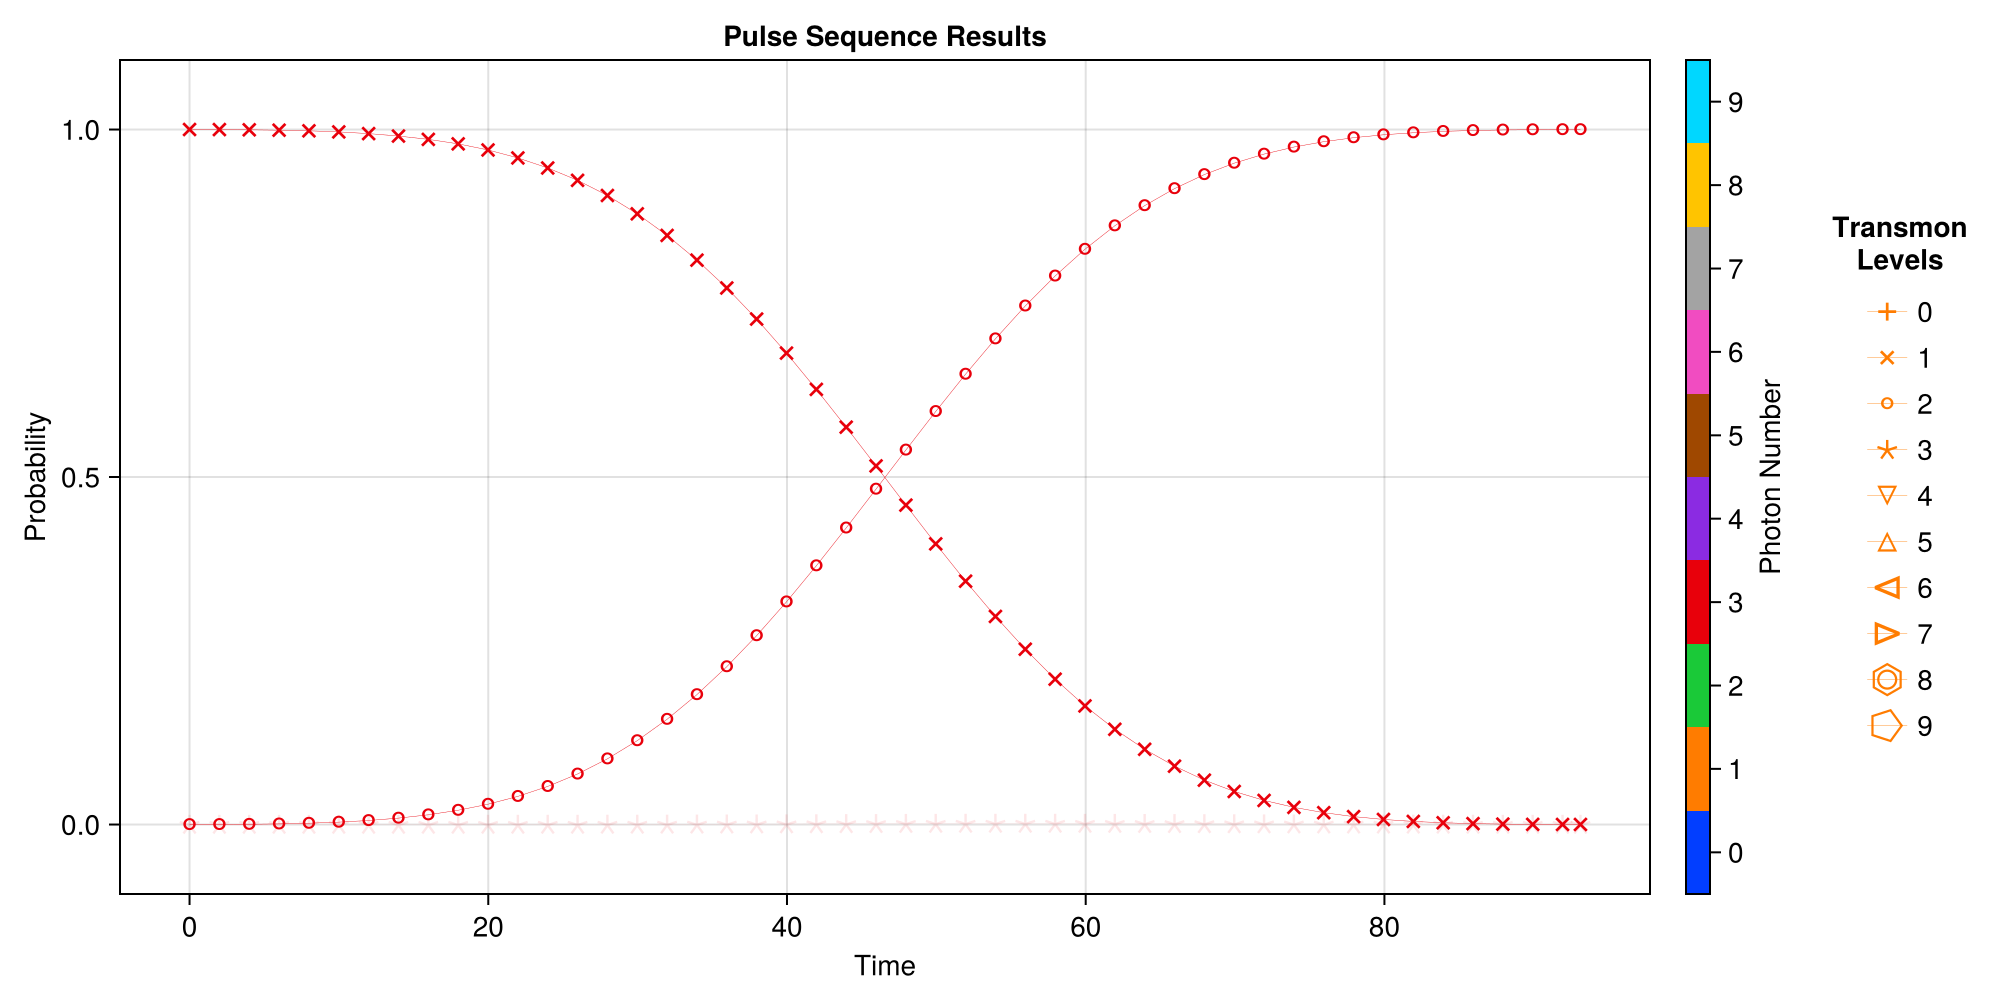

CairoMakie.Screen{IMAGE}


In [83]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, q_ef3_res["times"], EVs, plot_every = 10, emph_states = [(1,3),(2,3)])

In [84]:
EVs[(2, 3)][end]

0.9998890655048904 - 3.022814399324877e-17im

In [85]:
tot = 0
for key in keys(EVs)
    tot+=EVs[key][end]
end
tot

0.9999999999982038 - 2.968146511762809e-17im

### Half Qubit $|g0\rangle \to |g0\rangle+|e0\rangle$

In [86]:
starting_args = deepcopy(Mode4.Stuff["op_drive_params"]["q_ge_0"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]*0.5

ψ1 = Mode4.dressed_states[(0,0)]
ψ2 = Mode4.dressed_states[(0,0)] + Mode4.dressed_states[(1,0)]
ψ2 = ψ2/sqrt(2)

op = Mode4.dressed_states[(0,0)]*Mode4.dressed_states[(1,0)]'*2



t_range = [starting_args["pulse_time"], starting_args["pulse_time"]]


optimize_res_half_g0e0 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 1, check_op = op)

[2024-11-08 17:14:52] Info: On Level 1
[2024-11-08 17:14:52] Info: On Step 1: t = 93.125
[2024-11-08 17:14:52] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:14:54] Info: Time Evolution Complete
[2024-11-08 17:14:54] Info: Done with Level_1_step_1
[2024-11-08 17:14:54] Info: Using Check Op
[2024-11-08 17:14:54] Info: Accurace: 0.9995631286887051
[2024-11-08 17:14:54] Info: ------------------------------------------------------------------------------
[2024-11-08 17:14:54] Info: Highest Accuracy: 0.9995631286887051
[2024-11-08 17:14:54] Info: New ti: 93.125, new tf: 93.125
[2024-11-08 17:14:54] Info: ===================================================================================================	


Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999563
  "freq_d"        => 4.60391

In [87]:
#Mode4.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["q_half_ge0"] = deepcopy(optimize_res_half_g0e0)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 93.125
  "Envelope Args" => Dict{Any, Any}("sigma"=>23.2812, "mu"=>46.5625)
  "epsilon"       => 0.00269
  "Envelope"      => "Guassian"
  "shift"         => 0
  "accuracy"      => 0.999563
  "freq_d"        => 4.60391

In [88]:
ψ = Mode4.dressed_states[(0,0)]
res_half_ge0 = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["q_half_ge0"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T17:14:54.241
It is being saved at: Data/
[2024-11-08 17:14:54] Info: Running operator q_half_ge0
[2024-11-08 17:14:54] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 01s (ETA: 0h 00m 00s)
[2024-11-08 17:14:55] Info: Time Evolution Complete
[2024-11-08 17:14:55] Info: Saving Steps
[2024-11-08 17:14:56] Info: Done with Step_1
[2024-11-08 17:14:56] Info: Done With Running Sequence
[2024-11-08 17:14:56] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199839, 0.399678, 0.599517, 0.799356, 0.999195, 1.1990…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [89]:
EVs_Dict = SC.Utils.Get_EVs(res_half_ge0["states"], proj_dict);

[2024-11-08 17:14:56] Info: Making Plot


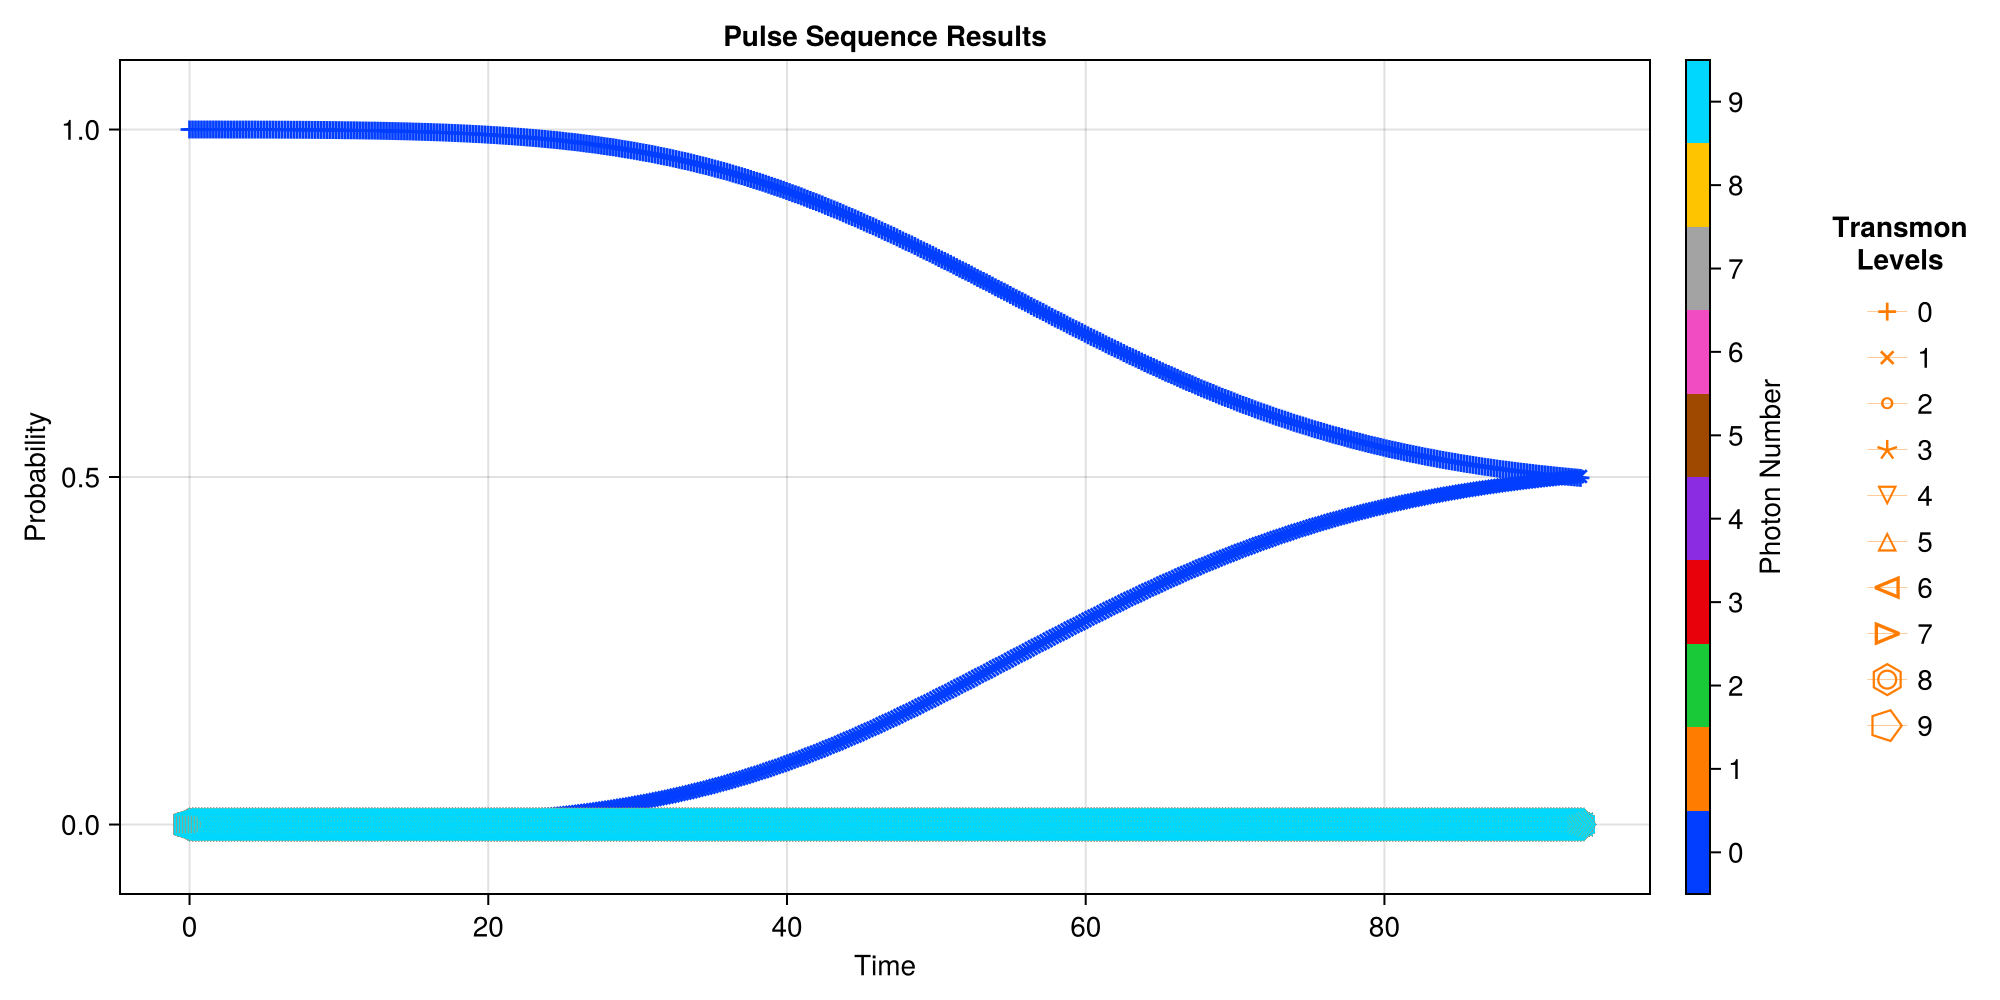

In [90]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, res_half_ge0["times"], EVs_Dict);

In [91]:
println(EVs_Dict[(0,0)][end])
println(EVs_Dict[(1,0)][end])

0.4987234827519325 - 4.700568520595025e-17im
0.5008418907411484 - 4.6222082443644464e-17im


## Sidebands at $\varepsilon = 0.84$

### Getting Stark Shift

[2024-11-08 18:08:23] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


[2024-11-08 18:08:53] Info: Done With Floquet Sweep
[2024-11-08 18:08:53] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0329644387960523	 0.002284225414517573	 2.104158637132685
Stark shift res: [0.0329644387960523, 208.05710999060827]


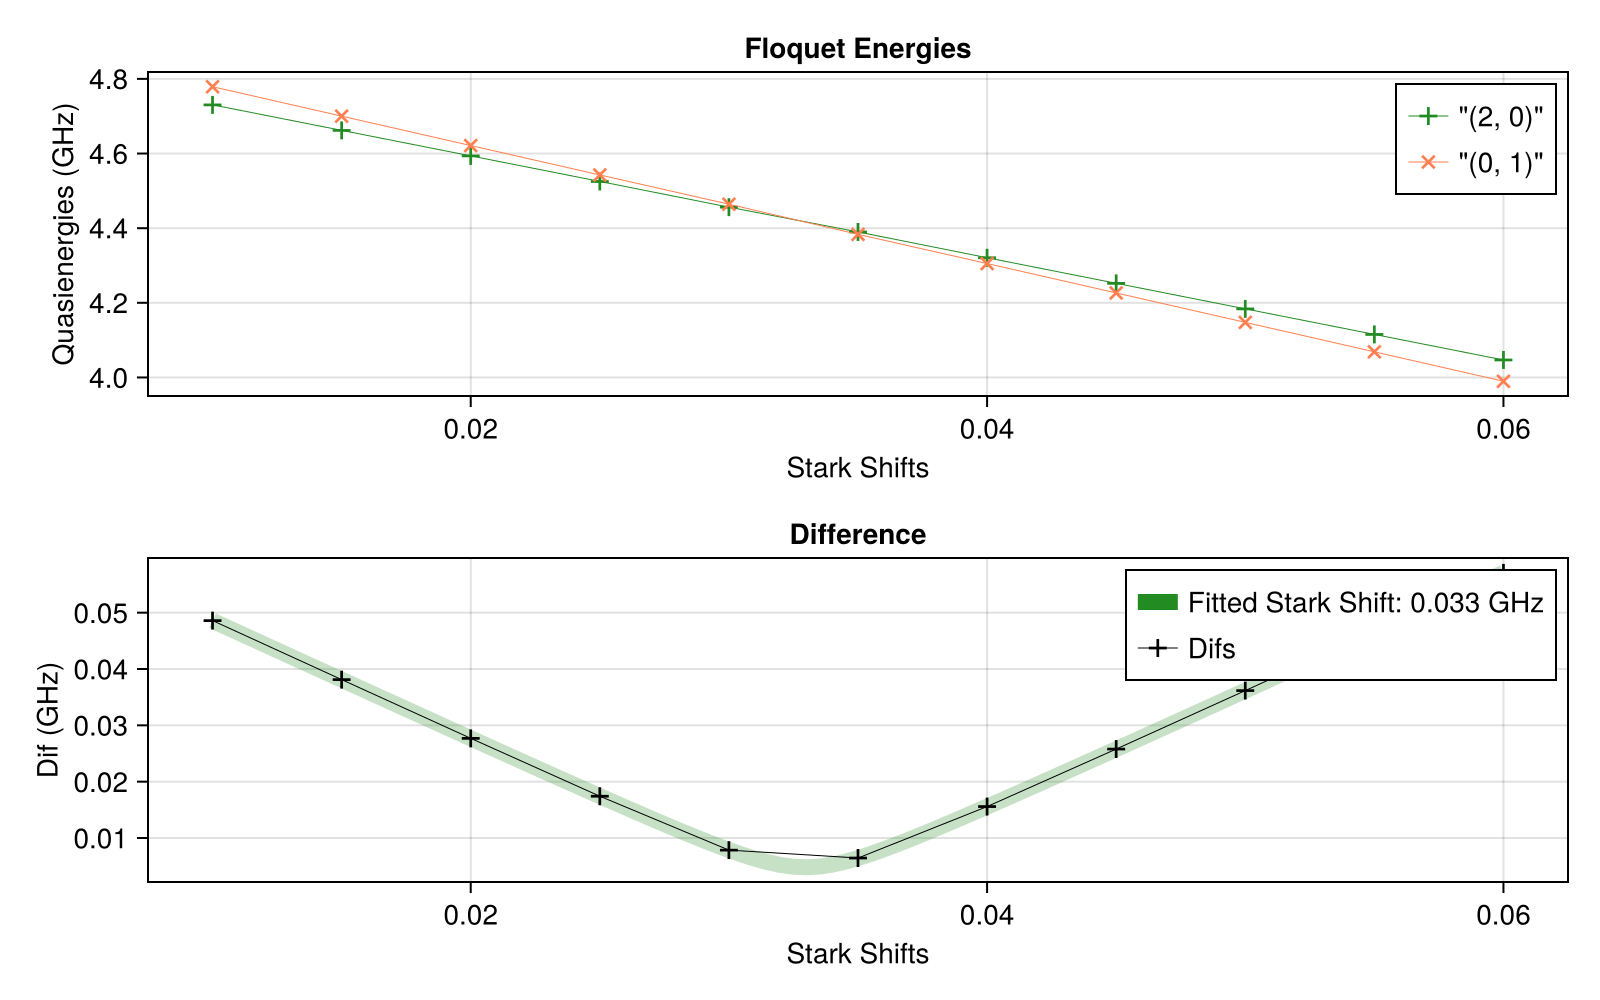

In [120]:
fngnp1_ε = 0.84
drive_op = Mode4.n̂ₜ
state1 = (2,0)
state2 = (0,1)

stark_shift_list = collect(LinRange(0.01, 0.06, 11))

stark_shift_res = SC.Dynamics.FindStarkShift(Mode4, state1, state2, fngnp1_ε, stark_shift_list)

println("Stark shift res: "*string(stark_shift_res))
fngnp1_stark_shift = stark_shift_res[1];
fngnp1_start_time = stark_shift_res[2];

In [121]:
fngnp1_ramp_time = 11.6257;

### f0->g1


In [122]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][4][1]*1000))
println("Target Pulse time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][4][1]*1000+fngnp1_ramp_time*2))

Target flattop time: 197.6376488095238
Target Pulse time: 220.88904880952379


In [123]:
ψ1 = Mode4.dressed_states[(2,0)]
ψ2 = Mode4.dressed_states[(0,1)]

freq_d = Mode4.dressed_energies[(0,1)]-Mode4.dressed_energies[(2,0)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time, fngnp1_start_time+fngnp1_ramp_time*2]

optimize_res_f0g1 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:08:53] Info: On Level 1
[2024-11-08 18:08:53] Info: On Step 1: t = 208.05710999060827
[2024-11-08 18:08:53] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 10s (ETA: 0h 00m 00s)
[2024-11-08 18:09:04] Info: Time Evolution Complete
[2024-11-08 18:09:04] Info: Done with Level_1_step_1
[2024-11-08 18:09:04] Info: Accurace: 0.9910052093669197
[2024-11-08 18:09:04] Info: ------------------------------------------------------------------------------
[2024-11-08 18:09:04] Info: On Step 2: t = 213.86995999060827
[2024-11-08 18:09:04] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 09s (ETA: 0h 00m 00s)
[2024-11-08 18:09:14] Info: Time Evolution Complete
[2024-11-08 18:09:14] Info: Done with Level_1_step_2
[2024-11-08 18:09:14] Info: Accurace: 0.9972362345054117
[2024-11-08 18:09:14] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 220.409
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>220.409, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.99968
  "freq_d"        => -2.61821

In [124]:
optimize_res_f0g1["pulse_time"]-optimize_res_f0g1["Envelope Args"]["ramp_time"]*2

197.15801624060825

In [125]:
#Mode4.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f0g1"] = deepcopy(optimize_res_f0g1)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 220.409
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>220.409, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.99968
  "freq_d"        => -2.61821

In [126]:
ψ = Mode4.dressed_states[(2,0)]
solver_kwargs = Dict{Any, Any}("abstol" => 1e-8, "reltol" => 1e-8)
sb_f0g1_res = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["sb_f0g1"], Return = true, clean_up = true, solver_kwargs = solver_kwargs)

The Name for this run is: Operator_Sequence_2024-11-08T18:19:56.741
It is being saved at: Data/
[2024-11-08 18:19:56] Info: Running operator sb_f0g1
[2024-11-08 18:19:56] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 11s (ETA: 0h 00m 00s)
[2024-11-08 18:20:08] Info: Time Evolution Complete
[2024-11-08 18:20:08] Info: Saving Steps
[2024-11-08 18:20:09] Info: Done with Step_1
[2024-11-08 18:20:09] Info: Done With Running Sequence
[2024-11-08 18:20:09] Info: Loading Data


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199827, 0.399654, 0.599482, 0.799309, 0.999136, 1.1989…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [127]:
EVs_f0g1 = SC.Utils.Get_EVs(sb_f0g1_res["states"], proj_dict);

[2024-11-08 18:20:09] Info: Making Plot


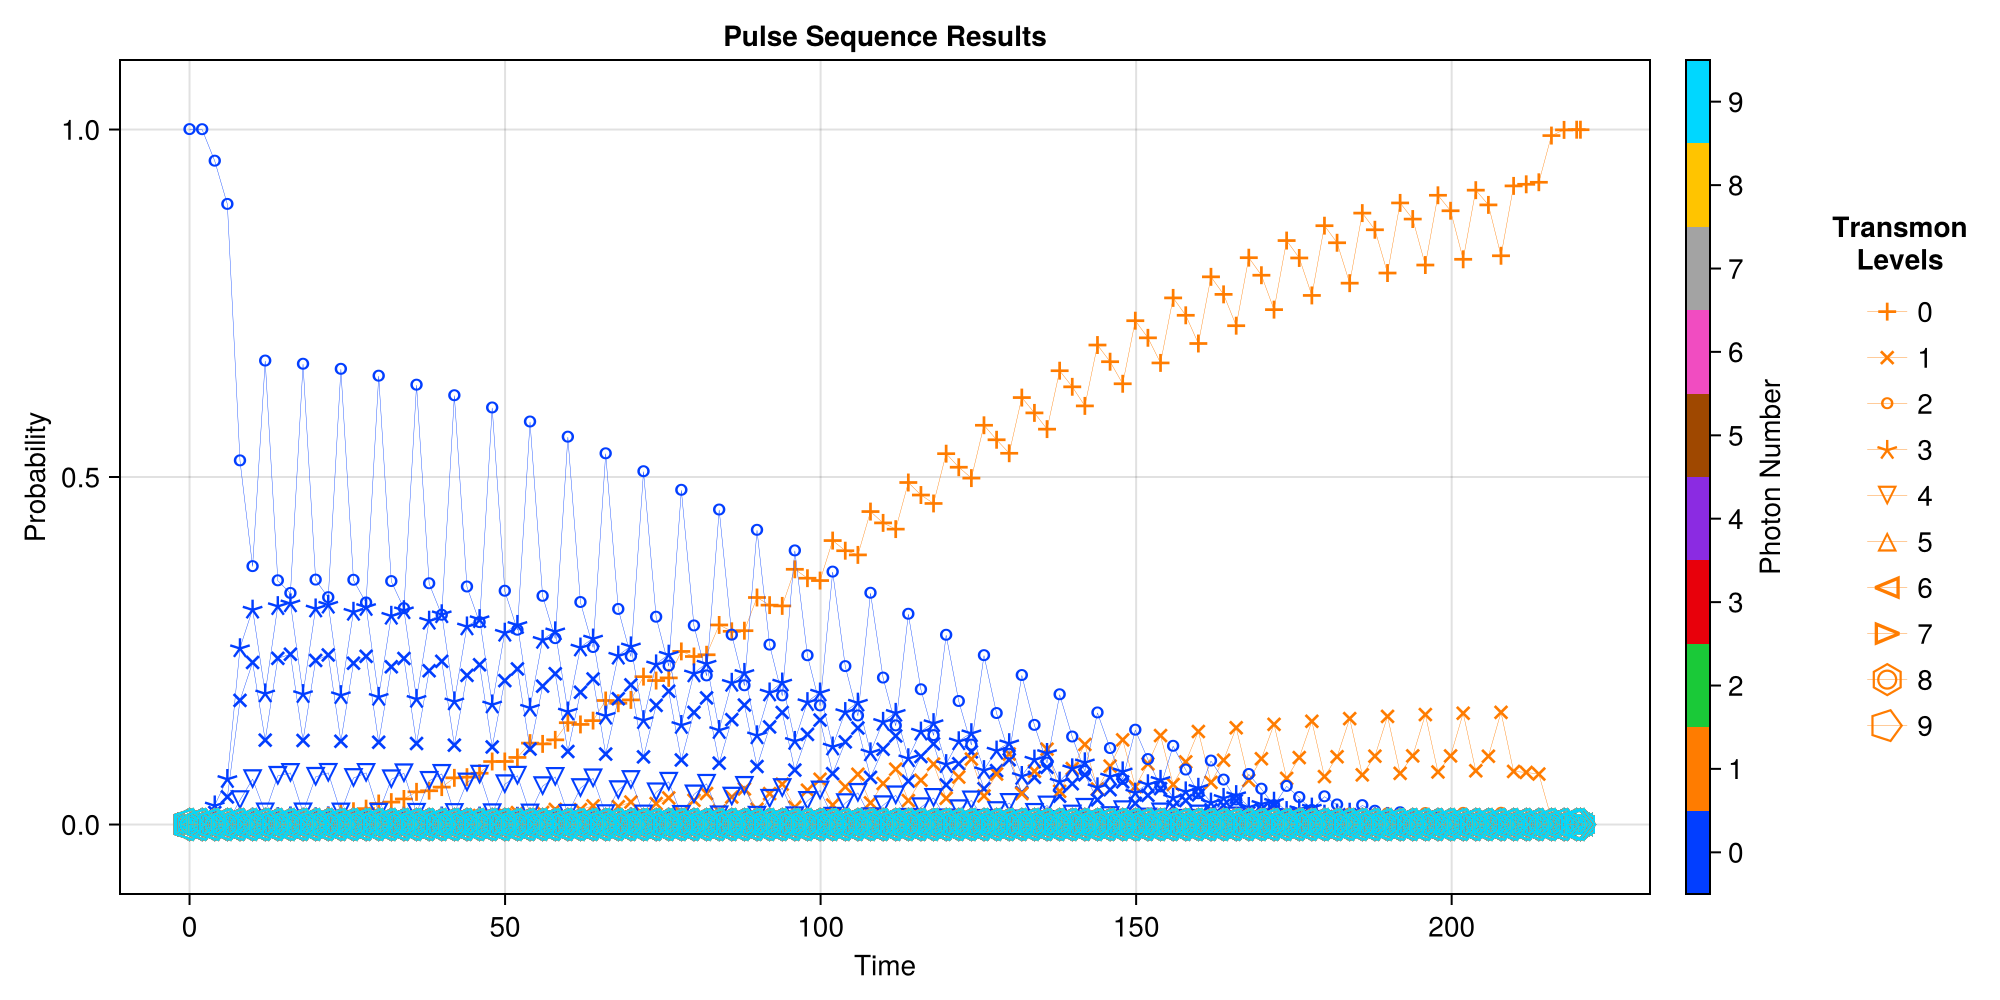

CairoMakie.Screen{IMAGE}


In [128]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, sb_f0g1_res["times"], EVs_f0g1, plot_every = 10)

### f1->g2


In [129]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][4][2]*1000))

Target flattop time: 220.8891369047619


In [130]:
ψ1 = Mode4.dressed_states[(2,1)]
ψ2 = Mode4.dressed_states[(0,2)]

freq_d = Mode4.dressed_energies[(0,2)]-Mode4.dressed_energies[(2,1)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)


t_range = [fngnp1_start_time/sqrt(2), fngnp1_start_time/sqrt(2)+fngnp1_ramp_time*2]


optimize_res_f1g2 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:20:10] Info: On Level 1
[2024-11-08 18:20:10] Info: On Step 1: t = 147.11859334843447
[2024-11-08 18:20:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 06s (ETA: 0h 00m 00s)
[2024-11-08 18:20:16] Info: Time Evolution Complete
[2024-11-08 18:20:16] Info: Done with Level_1_step_1
[2024-11-08 18:20:16] Info: Accurace: 0.9819546885189833
[2024-11-08 18:20:16] Info: ------------------------------------------------------------------------------
[2024-11-08 18:20:16] Info: On Step 2: t = 152.93144334843447
[2024-11-08 18:20:16] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 18:20:22] Info: Time Evolution Complete
[2024-11-08 18:20:22] Info: Done with Level_1_step_2
[2024-11-08 18:20:22] Info: Accurace: 0.9942782053681752
[2024-11-08 18:20:22] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 159.471
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>159.471, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.999066
  "freq_d"        => -2.61783

In [131]:
optimize_res_f1g2["pulse_time"]-optimize_res_f1g2["Envelope Args"]["ramp_time"]*2

136.21949959843448

In [132]:
#Mode4.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f1g2"] = deepcopy(optimize_res_f1g2)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 159.471
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>159.471, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.999066
  "freq_d"        => -2.61783

### f2->g3

In [141]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][4][3]*1000))

Target flattop time: 111.60714285714285


In [134]:
ψ1 = Mode4.dressed_states[(2,2)]
ψ2 = Mode4.dressed_states[(0,3)]

freq_d = Mode4.dressed_energies[(0,3)]-Mode4.dressed_energies[(2,2)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(3), fngnp1_start_time/sqrt(3)+fngnp1_ramp_time*2]

optimize_res_f2g3 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:23:14] Info: On Level 1
[2024-11-08 18:23:14] Info: On Step 1: t = 120.12182845989327
[2024-11-08 18:23:14] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-11-08 18:23:20] Info: Time Evolution Complete
[2024-11-08 18:23:20] Info: Done with Level_1_step_1
[2024-11-08 18:23:20] Info: Accurace: 0.9729497920159355
[2024-11-08 18:23:20] Info: ------------------------------------------------------------------------------
[2024-11-08 18:23:20] Info: On Step 2: t = 125.93467845989326
[2024-11-08 18:23:20] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 18:23:24] Info: Time Evolution Complete
[2024-11-08 18:23:24] Info: Done with Level_1_step_2
[2024-11-08 18:23:24] Info: Accurace: 0.9913016042336655
[2024-11-08 18:23:24] Info: ------------------------------------------------------------------------------
[20

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 132.474
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>132.474, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.998415
  "freq_d"        => -2.61746

In [135]:
optimize_res_f2g3["pulse_time"]-optimize_res_f2g3["Envelope Args"]["ramp_time"]*2

109.22273470989323

In [136]:
#Mode4.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f2g3"] = deepcopy(optimize_res_f2g3)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 132.474
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>132.474, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.998415
  "freq_d"        => -2.61746

### f3->g4

In [137]:
println("Target flattop time: "*string(device_config["device"]["soc"]["sideband"]["pulses"]["fngnp1pi_times"][4][4]*1000))

Target flattop time: 95.33110119047619


In [138]:
ψ1 = Mode4.dressed_states[(2,3)]
ψ2 = Mode4.dressed_states[(0,4)]

freq_d = Mode4.dressed_energies[(0,4)]-Mode4.dressed_energies[(2,3)]

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>fngnp1_ramp_time, "k" => 2, "pulse_time" => 0)

t_range = [fngnp1_start_time/sqrt(4), fngnp1_start_time/sqrt(4)+fngnp1_ramp_time*2]

optimize_res_f3g4 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, fngnp1_ε, freq_d, fngnp1_stark_shift, t_range, envelope, envelope_args)

[2024-11-08 18:25:10] Info: On Level 1
[2024-11-08 18:25:10] Info: On Step 1: t = 104.02855499530413
[2024-11-08 18:25:10] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 18:25:15] Info: Time Evolution Complete
[2024-11-08 18:25:15] Info: Done with Level_1_step_1
[2024-11-08 18:25:15] Info: Accurace: 0.9640064776752254
[2024-11-08 18:25:15] Info: ------------------------------------------------------------------------------
[2024-11-08 18:25:15] Info: On Step 2: t = 109.84140499530413
[2024-11-08 18:25:15] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 04s (ETA: 0h 00m 00s)
[2024-11-08 18:25:20] Info: Time Evolution Complete
[2024-11-08 18:25:20] Info: Done with Level_1_step_2
[2024-11-08 18:25:20] Info: Accurace: 0.988329908554412
[2024-11-08 18:25:20] Info: ------------------------------------------------------------------------------
[202

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 116.381
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>116.381, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.997759
  "freq_d"        => -2.61709

In [139]:
optimize_res_f3g4["pulse_time"]-optimize_res_f3g4["Envelope Args"]["ramp_time"]*2

93.12946124530414

In [140]:
#Mode4.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4_eps78)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f3g4"] = deepcopy(optimize_res_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 116.381
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>116.381, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.84
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.0329644
  "accuracy"      => 0.997759
  "freq_d"        => -2.61709

## Other Specific Gates

### Special Side Bands

#### f1_2pi_g3

##### Getting Drive Strength and Stark Shift

In [12]:
n1 = 1
n2 = 3

freq1 = Mode4.dressed_energies[(2,n1)]-Mode4.dressed_energies[(0,n1+1)]
freq2 = Mode4.dressed_energies[(2,n2)]-Mode4.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f1_2pi_g3 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.45
println("Required Epsilon: $eps_f1_2pi_g3")

χ: 0.0007495557225229987
m: 1.4142135623730951
n: 1
Required Epsilon: 0.11925358521146878


[2024-11-08 18:44:55] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


[2024-11-08 18:45:19] Info: Done With Floquet Sweep
[2024-11-08 18:45:19] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0006878946790761179	 0.0004908543133158179	 2.002156464052207


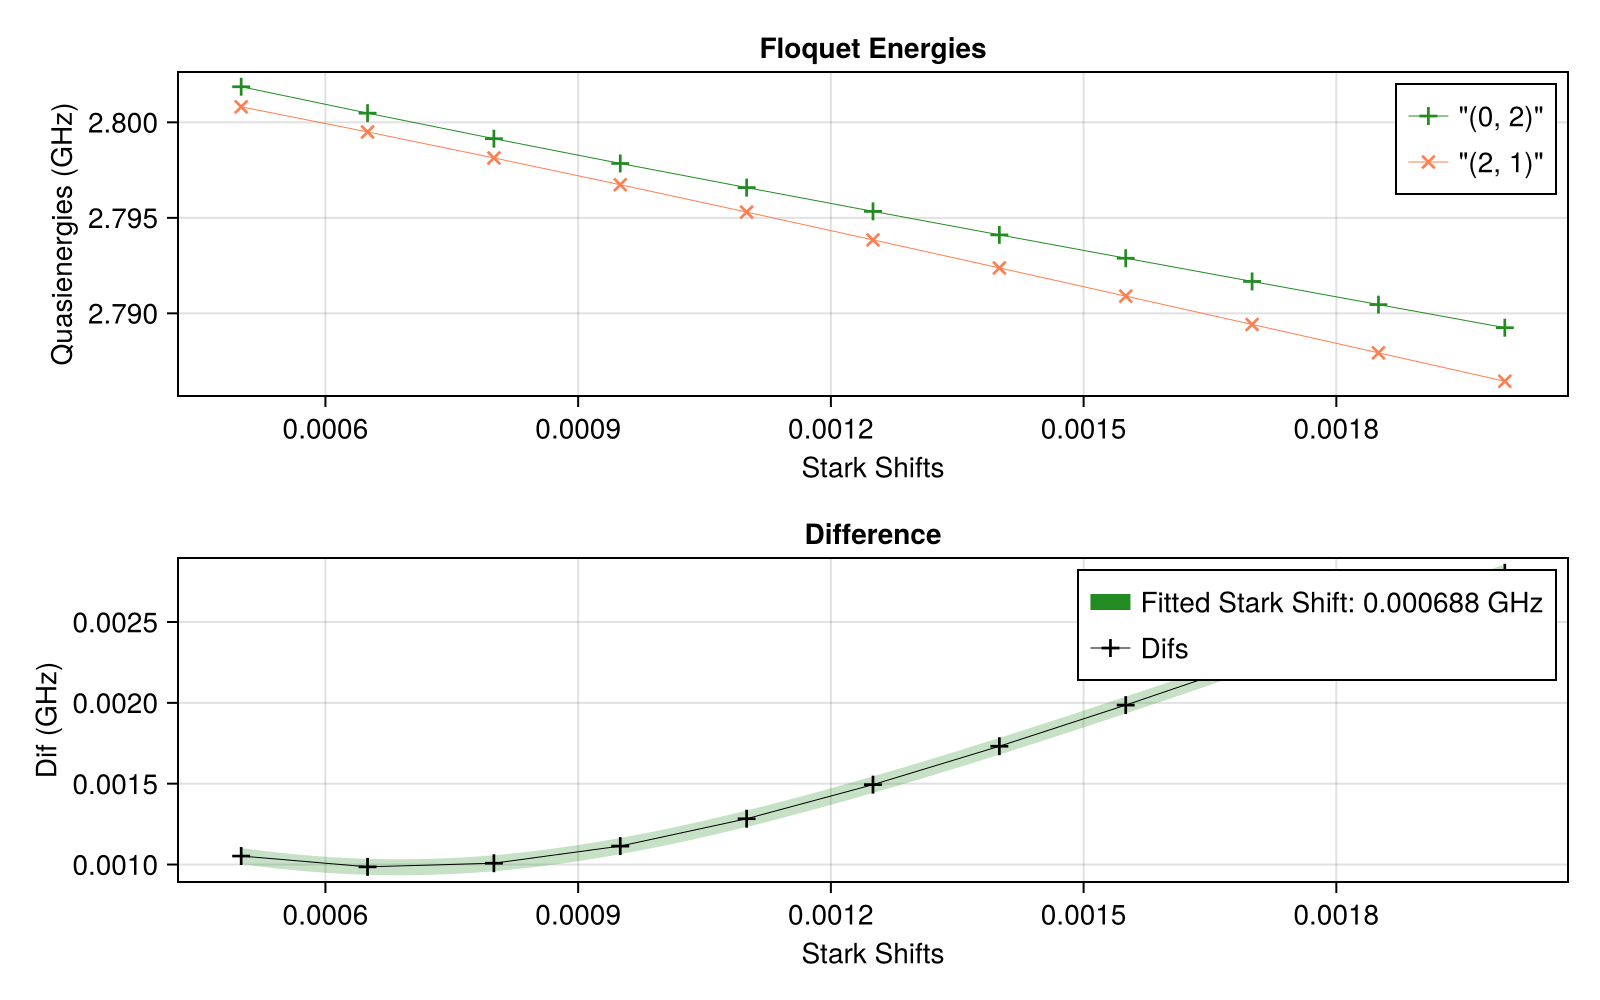

2-element Vector{Float64}:
    0.0006878946790761179
 1017.535042687199

In [13]:
ε = eps_f1_2pi_g3
drive_op = Mode4.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

#stark_shift_list = collect(LinRange(0.0005, 0.002, 11))
stark_shift_list = collect(LinRange(0.0005, 0.002, 11))

stark_shift_res_f0_2pi_g3 = SC.Dynamics.FindStarkShift(Mode4, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [14]:
n2

3

In [15]:
ψ1 = Mode4.dressed_states[(2,n1)]+Mode4.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode4.dressed_states[(0,n1+1)]+Mode4.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)


freq_d = Mode4.dressed_energies[(0,n1+1)]-Mode4.dressed_energies[(2, n1)]

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

check_op = Mode4.dressed_states[(0,n1+1)]*Mode4.dressed_states[(2,n2)]'*2

stark_shift = stark_shift_res_f0_2pi_g3[1]
initial_time = stark_shift_res_f0_2pi_g3[2]

t_range = [initial_time*0.99, initial_time*1.01]

optimize_res_f1g2_2pi_f3g4 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, eps_f1_2pi_g3, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 7, check_op = check_op);

[2024-11-08 18:45:19] Info: On Level 1
[2024-11-08 18:45:19] Info: On Step 1: t = 1007.359692260327
[2024-11-08 18:45:19] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 52s (ETA: 0h 00m 00s)
[2024-11-08 18:46:12] Info: Time Evolution Complete
[2024-11-08 18:46:12] Info: Done with Level_1_step_1
[2024-11-08 18:46:12] Info: Using Check Op
[2024-11-08 18:46:12] Info: Accurace: 0.9987712524551813
[2024-11-08 18:46:12] Info: ------------------------------------------------------------------------------
[2024-11-08 18:46:12] Info: On Step 2: t = 1010.7514757359511
[2024-11-08 18:46:12] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 55s (ETA: 0h 00m 00s)
[2024-11-08 18:47:07] Info: Time Evolution Complete
[2024-11-08 18:47:07] Info: Done with Level_1_step_2
[2024-11-08 18:47:07] Info: Using Check Op
[2024-11-08 18:47:07] Info: Accurace: 0.998640945729159
[2024-11-08 18:47:07] Info

In [16]:
optimize_res_f1g2_2pi_f3g4["pulse_time"] - optimize_res_f1g2_2pi_f3g4["Envelope Args"]["ramp_time"]*2

984.1082922603271

In [18]:
#Mode4.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f1g2_2pi_f3g4"] = deepcopy(optimize_res_f1g2_2pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1007.36
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1007.36, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.119254
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000687895
  "accuracy"      => 0.998771
  "freq_d"        => -2.61783

In [19]:
ψ = Mode4.dressed_states[(2,1)]+Mode4.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f1g2_2pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["sb_f1g2_2pi_f3g4"], Return = true, clean_up = true)

The Name for this run is: Operator_Sequence_2024-11-08T18:51:27.683
It is being saved at: Data/
[2024-11-08 18:51:27] Info: Running operator sb_f1g2_2pi_f3g4
[2024-11-08 18:51:27] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 15s (ETA: 0h 00m 00s)
[2024-11-08 18:51:43] Info: Time Evolution Complete
[2024-11-08 18:51:43] Info: Saving Steps
[2024-11-08 18:51:49] Info: Done with Step_1
[2024-11-08 18:51:49] Info: Done With Running Sequence
[2024-11-08 18:51:49] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.199992, 0.399984, 0.599976, 0.799968, 0.99996, 1.19995…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [20]:
EVs_Dict = SC.Utils.Get_EVs(res_f1g2_2pi_f3g4["states"], proj_dict);

[2024-11-08 18:51:55] Info: Making Plot


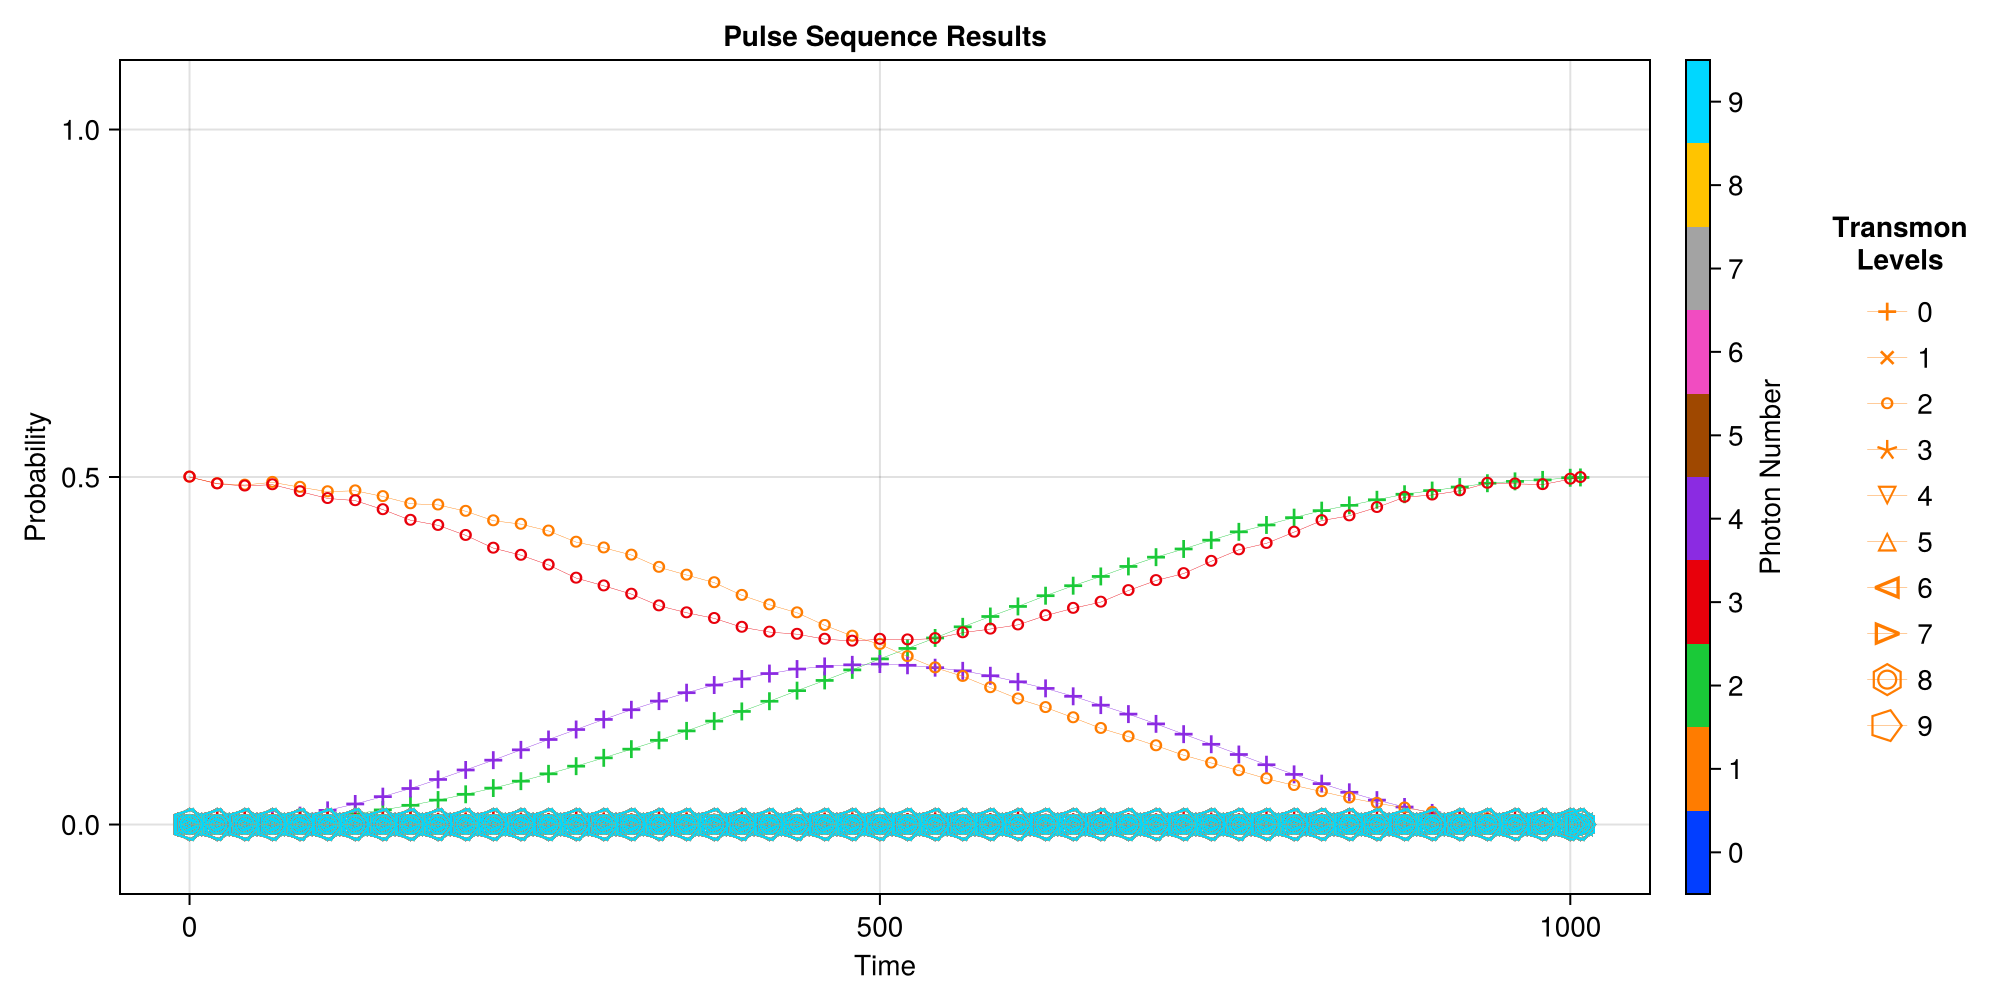

CairoMakie.Screen{IMAGE}


In [21]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, res_f1g2_2pi_f3g4["times"], EVs_Dict, plot_every = 100)

In [22]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,2)][end])

0.4993479560584237 - 8.134344511764813e-17im
0.4994232990294629 - 3.930351193683664e-17im


#### f0_4pi_g3

##### Getting Drive Strength and Stark Shift

In [5]:
n1 = 0
n2 = 3

freq1 = Mode4.dressed_energies[(2,n1)]-Mode4.dressed_energies[(0,n1+1)]
freq2 = Mode4.dressed_energies[(2,n2)]-Mode4.dressed_energies[(0,n2+1)]

χ = abs(freq1-freq2)
println("χ: $χ")

m = sqrt(2)^(abs(n2-n1)-1)
println("m: $m")

n = Int(floor(m/2)+1)
println("n: $n")

eps_f0g1_4pi_f3g4 = 1000*χ/(2*(4*n^2-m^2)^(1/2))*0.66
println("Required Epsilon: $eps_f0g1_4pi_f3g4")

χ: 0.0011244228538789258
m: 2.0000000000000004
n: 2
Required Epsilon: 0.10711566316604423


[2024-11-10 15:10:30] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


[2024-11-10 15:10:45] Info: Done With Floquet Sweep
[2024-11-10 15:10:46] Info: Fit Stuff: 3-element Vector{Float64}:	 0.0005556383078606569	 0.00031192491461576354	 2.0017406617829985


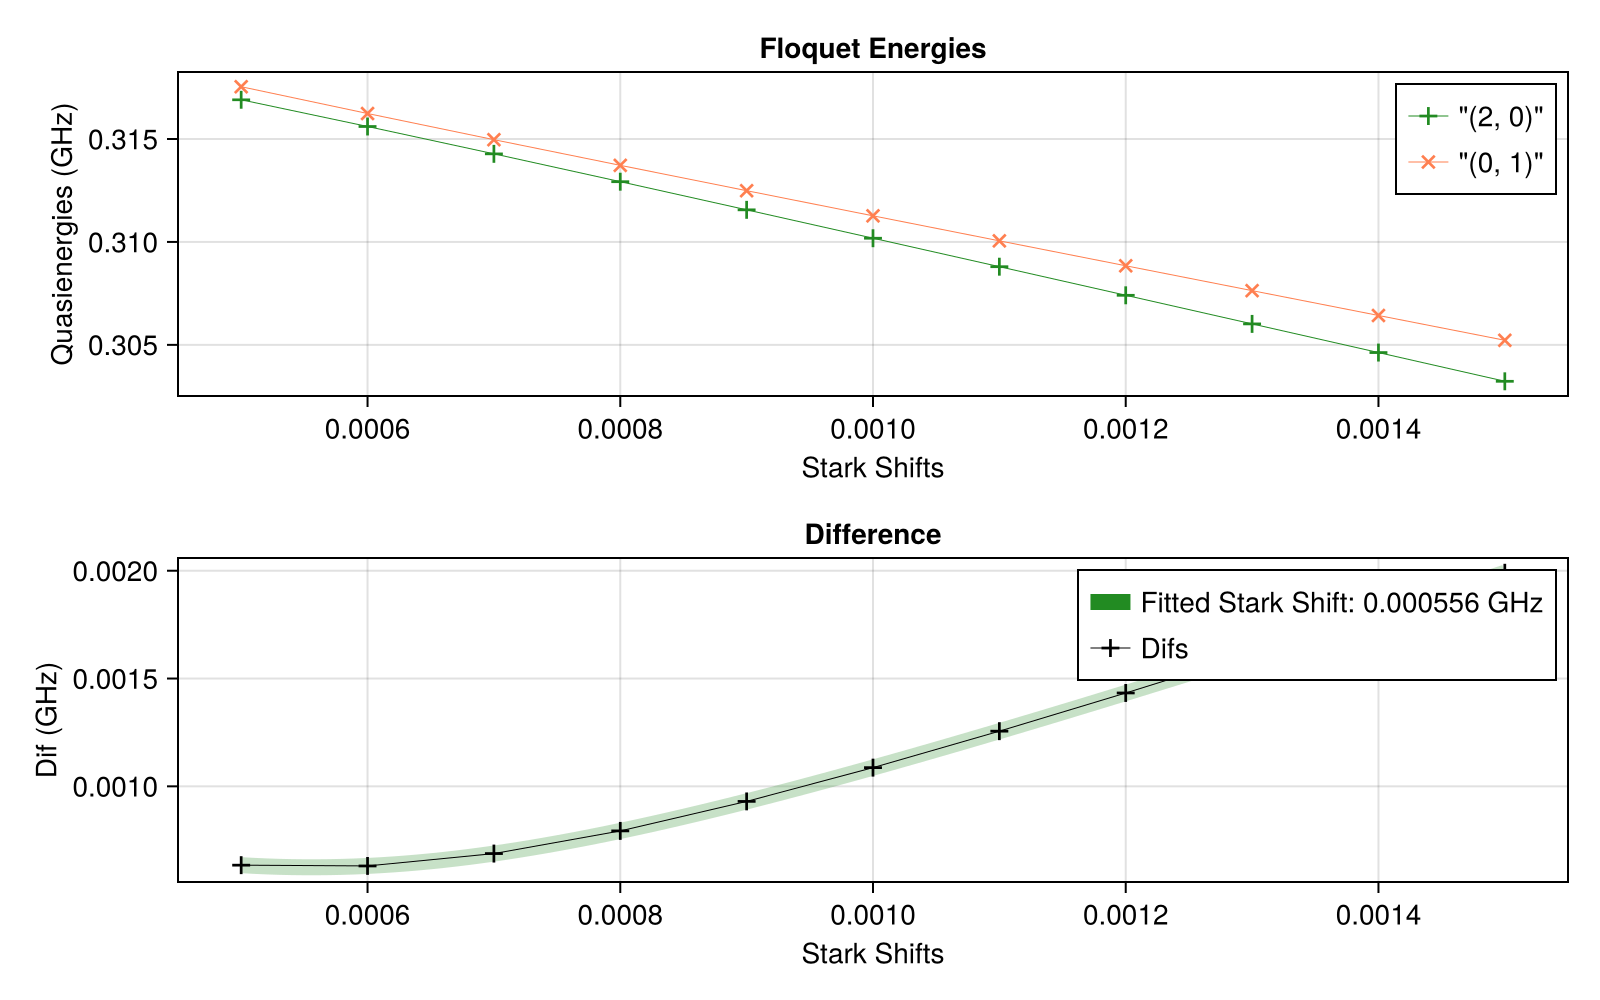

2-element Vector{Float64}:
    0.0005556383078606569
 1601.5559820805472

In [6]:
ε = eps_f0g1_4pi_f3g4
drive_op = Mode4.n̂ₜ
state1 = (2,n1)
state2 = (0,n1+1)

stark_shift_list = collect(LinRange(0.0005, 0.0015, 11))

stark_shift_res_f0g1_4pi_f3g4 = SC.Dynamics.FindStarkShift(Mode4, state1, state2, ε, stark_shift_list)

##### Optimizing Pulse

In [7]:
ψ1 = Mode4.dressed_states[(2,n1)]+Mode4.dressed_states[(2,n2)]
ψ1 = ψ1/qt.norm(ψ1)
ψ2 = Mode4.dressed_states[(0,n1+1)]+Mode4.dressed_states[(2,n2)]
ψ2 = ψ2/qt.norm(ψ2)

freq_d = Mode4.dressed_energies[(0,n1+1)]-Mode4.dressed_energies[(2, n1)]

check_op = 2*Mode4.dressed_states[(0,n1+1)]*Mode4.dressed_states[(2,n2)]'

ramp_time = 11.6257

envelope = "Bump_Ramp"
envelope_args = Dict{Any, Any}("ramp_time" =>ramp_time, "k" => 2, "pulse_time" => 0)

stark_shift = stark_shift_res_f0g1_4pi_f3g4[1]
initial_time = stark_shift_res_f0g1_4pi_f3g4[2]

ν = abs((stark_shift+freq_d))
t_range = [initial_time, initial_time+2*ramp_time]

optimize_res_f0g1_4pi_f3g4 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, eps_f0g1_4pi_f3g4, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 1, samples_per_level = 2, check_op = check_op)

[2024-11-10 15:10:57] Info: On Level 1
[2024-11-10 15:10:57] Info: On Step 1: t = 1601.5559820805472
[2024-11-10 15:10:57] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 28s (ETA: 0h 00m 00s)
[2024-11-10 15:11:26] Info: Time Evolution Complete
[2024-11-10 15:11:26] Info: Done with Level_1_step_1
[2024-11-10 15:11:26] Info: Using Check Op
[2024-11-10 15:11:26] Info: Accurace: 0.9977187775387317
[2024-11-10 15:11:26] Info: ------------------------------------------------------------------------------
[2024-11-10 15:11:26] Info: On Step 2: t = 1624.8073820805473
[2024-11-10 15:11:26] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 28s (ETA: 0h 00m 00s)
[2024-11-10 15:11:55] Info: Time Evolution Complete
[2024-11-10 15:11:55] Info: Done with Level_1_step_2
[2024-11-10 15:11:55] Info: Using Check Op
[2024-11-10 15:11:55] Info: Accurace: 0.9937538842422378
[2024-11-10 15:11:55] In

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1601.56
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1601.56, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.107116
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000555638
  "accuracy"      => 0.997719
  "freq_d"        => -2.61821

In [8]:
#Mode4.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_f0g1_4pi_f3g4"] = deepcopy(optimize_res_f0g1_4pi_f3g4)
end

Dict{Any, Any} with 7 entries:
  "pulse_time"    => 1601.56
  "Envelope Args" => Dict{Any, Any}("pulse_time"=>1601.56, "k"=>2, "ramp_time"=…
  "epsilon"       => 0.107116
  "Envelope"      => "Bump_Ramp"
  "shift"         => 0.000555638
  "accuracy"      => 0.997719
  "freq_d"        => -2.61821

In [9]:
ψ = Mode4.dressed_states[(2,0)]+Mode4.dressed_states[(2,3)]
ψ = ψ/sqrt(2)
res_f0g1_4pi_f3g4 = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["sb_f0g1_4pi_f3g4"], Return = true, clean_up = true, spns = 1)

The Name for this run is: Operator_Sequence_2024-11-10T15:11:55.972
It is being saved at: Data/
[2024-11-10 15:11:55] Info: Running operator sb_f0g1_4pi_f3g4
[2024-11-10 15:11:55] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 28s (ETA: 0h 00m 00s)
[2024-11-10 15:12:24] Info: Time Evolution Complete
[2024-11-10 15:12:24] Info: Saving Steps
[2024-11-10 15:12:28] Info: Done with Step_1
[2024-11-10 15:12:28] Info: Done With Running Sequence
[2024-11-10 15:12:28] Info: Loading Data


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Dict{Any, Any} with 2 entries:
  "times"  => Any[0.0, 0.999723, 1.99945, 2.99917, 3.99889, 4.99861, 5.99834, 6…
  "states" => Any[Quantum Object:   type=Ket   dims=[10, 10]   size=(100,)…

In [10]:
EVs_Dict = SC.Utils.Get_EVs(res_f0g1_4pi_f3g4["states"], proj_dict);

[2024-11-10 15:12:32] Info: Making Plot


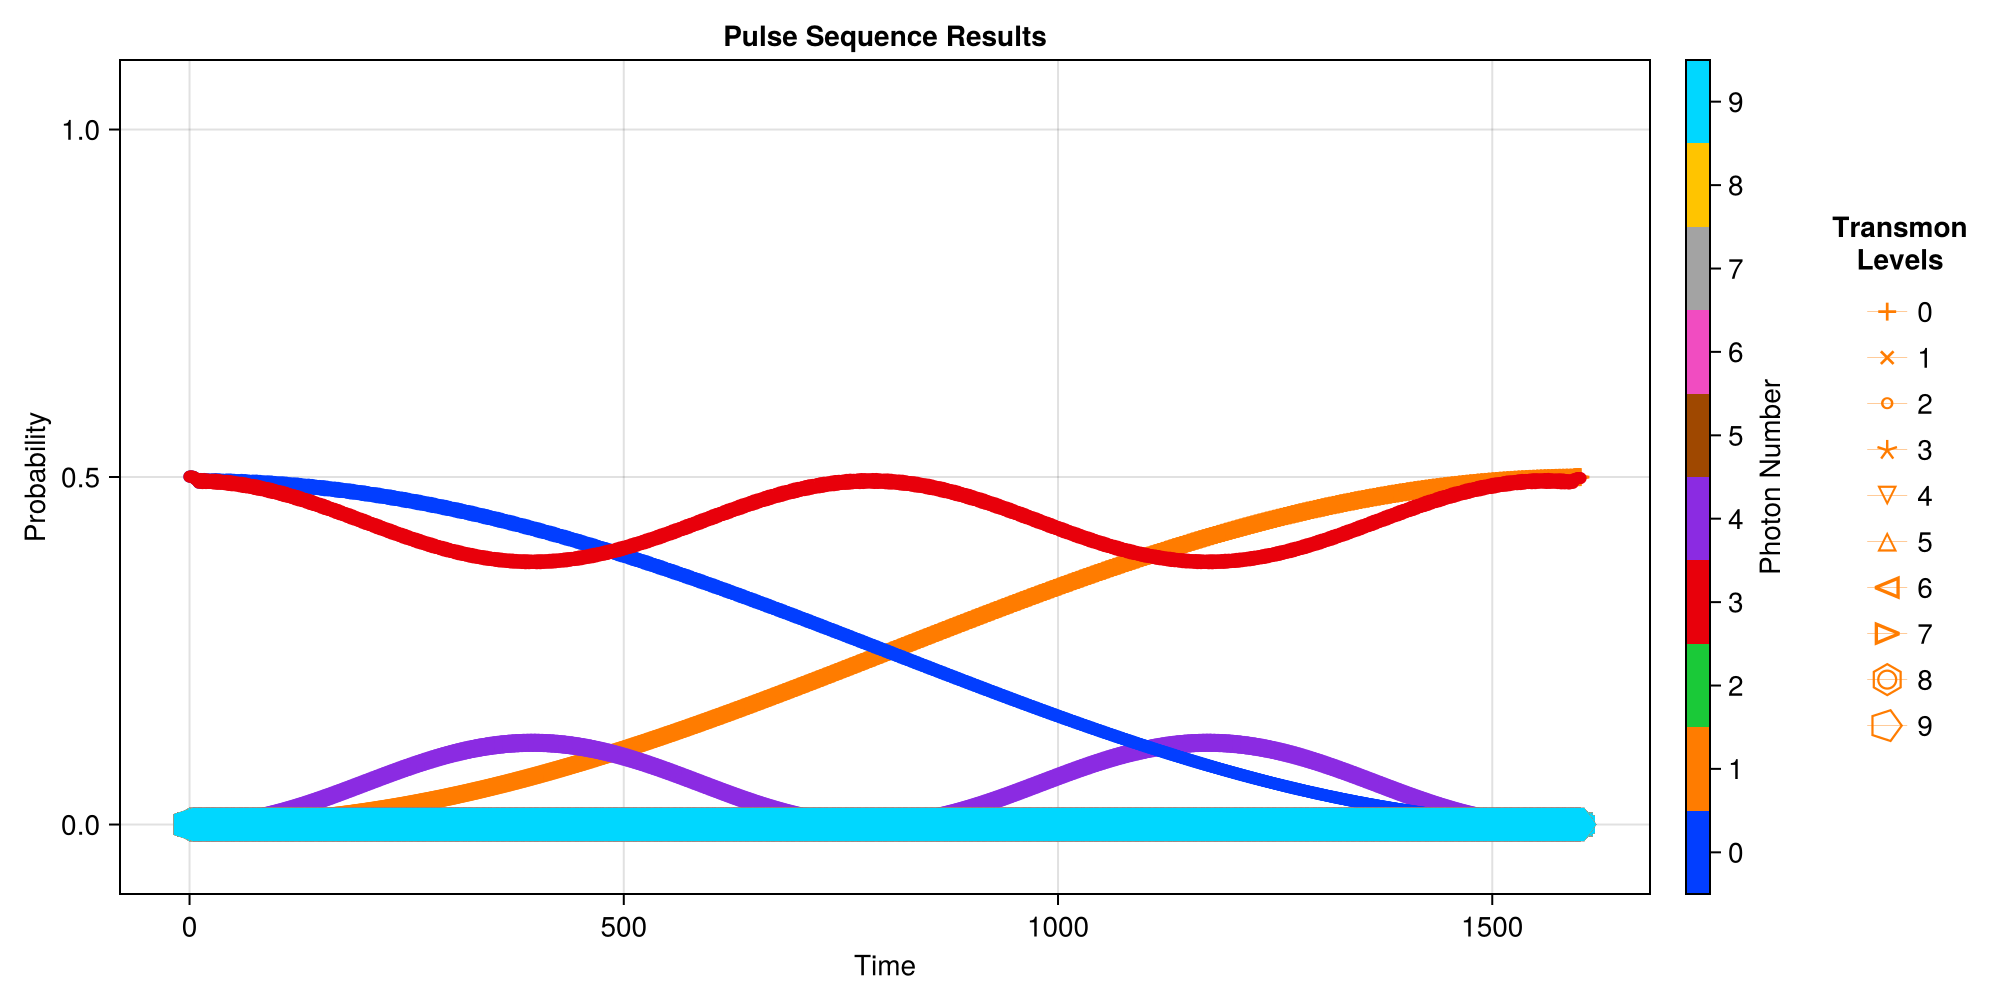

CairoMakie.Screen{IMAGE}


In [11]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, res_f0g1_4pi_f3g4["times"], EVs_Dict)

In [12]:
println(EVs_Dict[(2,3)][end])
println(EVs_Dict[(0,1)][end])

0.4978332439798684 + 3.57665319314932e-17im
0.49988444692845413 - 3.4827321095366517e-17im


#### Half Sideband $|f1\rangle \to |f1\rangle+|g2\rangle$

In [ ]:
Mode4.Stuff["op_drive_params"]["sb_f1g2"]["pulse_time"]

In [ ]:
starting_args = deepcopy(Mode4.Stuff["op_drive_params"]["sb_f1g2"])

envelope_args = starting_args["Envelope Args"]
envelope = starting_args["Envelope"]
freq_d = starting_args["freq_d"]
stark_shift = starting_args["shift"]
ε = starting_args["epsilon"]

ψ1 = Mode4.dressed_states[(2,1)]
ψ2 = Mode4.dressed_states[(2,1)] + Mode4.dressed_states[(0,2)]
ψ2 = ψ2/sqrt(2)

proj_op = Mode4.dressed_states[(2,1)]*Mode4.dressed_states[(0,2)]'
op = 2*proj_op# proj_dict[(2,1)]+proj_dict[(0,2)]


t_range = [69.8, 70.2]
t_range = [70.8, 71.2]
t_range = [60, 88]


optimize_res_half_f1g2 = SC.Dynamics.OptimizePulse(Mode4, ψ1, ψ2, ε, freq_d, stark_shift, t_range, envelope, envelope_args, levels = 5, samples_per_level = 25, check_op = op)

In [ ]:
#Mode4.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
if GLOBAL_SAVE_CALIBRATE | false
    Mode4.Stuff["op_drive_params"]["sb_half_f1g2"] = deepcopy(optimize_res_half_f1g2)
end

In [ ]:
ψ = Mode4.dressed_states[(2,1)]
res_half_f1g2 = SC.Dynamics.RunPulseSequence(Mode4, ψ, ["sb_half_f1g2"], Return = true, clean_up = true)

In [ ]:
EVs_Dict = SC.Utils.Get_EVs(res_half_f1g2["states"], proj_dict);

In [ ]:
SC.Dynamics.PlotSingleModeEvolution(Mode4, res_half_f1g2["times"], EVs_Dict)

In [ ]:
println(EVs_Dict[(2,1)][end])
println(EVs_Dict[(0,2)][end])